# Comparing Several Discrete Choice Models (Features + Constant)

- - -

W. Ross Morrow ([wrossmorrow@stanford.edu](mailto:wrossmorrow@stanford.edu), [wrossmorrow.com](https://wrossmorrow.com))

Research Analytics Consultant, Stanford GSB

February 5th, 2019

- - -

# Introduction 

- - - - 

In this notebook we'll compare several Discrete Choice Models in a simple situation: single-feature binary choice data. Specifically, the data will be composed of a number of observations, $N$, a number of individuals, $I$, an individual index per observations $i_n$, a "feature level" $x_n$ per observation, and a "yes/no" dummy $y_n \in \{\pm 1\}$ standing in for random (but structured) choices. We can draw those choices with a variety of data generating processes, as discussed below. But the basic setup is that we see some number of repeated trials for different individuals in which they answer "yes" or "no" to some question, and our broad goal is to model the frequency with which respondents say "yes" or "no". 

First, lets do our basic imports and function definitions. We'll discuss the models for data $(N,I,\mathbf{i},\mathbf{x},\mathbf{y})$ below. 

In [52]:
import os
import argparse
import time
from multiprocessing import Pool , Queue , Process
from multiprocessing.pool import ThreadPool

import string
import random

import numpy as np
from numpy.random import rand , randn , randint , choice

import cvxpy as cp
import ecos

from scipy.sparse import csc_matrix , csr_matrix , coo_matrix , issparse
from scipy.optimize import minimize , LinearConstraint , BFGS
from scipy.stats import norm as gaussian , normaltest

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
%matplotlib notebook
        

These are some wrappers around random number generation that are useful here. 

In [53]:

def randi(A,N) : return randint(0,high=A,size=N) 

def rands(N) : return np.sign( 2.0*rand(N) - 1.0 )

def randc(C,N,p) : return choice( C , size=N , p=p )

def randp(A,N) : 
    L , R = randi(A,N) , randi(A-1,N)
    R[ np.where( R >= L )[0] ] += 1
    return L , R

def random_string( l ) : 
    return ''.join( random.choice(string.ascii_letters) for m in range(l) )


This is a nice simple way to plot sparsity patterns for not-too-large sparse matrices. 

In [54]:

def spy( A , b=None ) : 
    plt.figure( figsize=(10,3) )
    plt.xticks([]) ; plt.yticks([])
    if issparse(A) : A = A.toarray()
    if b is None : 
        plt.imshow( A != 0 , cmap='Greys' , interpolation='nearest', aspect='auto' )
    else : 
        X = np.zeros( ( A.shape[0] , A.shape[1]+4 ) )
        X[:,:A.shape[1]] = A
        X[:,A.shape[1]+3] = b
        plt.imshow( X != 0 , cmap='Greys' , interpolation='nearest', aspect='auto' )
        

In [55]:
class DataGeneratingProcess( object ) : 
    
    def __init__( self ) : 
        pass
    
    def draw( self , N , I , i , x ) : 
        pass
    

# Models

- - -

Below we review Logit, Latent Class Logit, Random Coefficient Logit, and `idLogit` models and provide code for this specific (and rather simple) situation. 

First, however, we define a general class `FittableModel` each model-specific class will be derived from. This class has a timeout-enabled fitting method as well as derivative checking routines for gradients and Hessian-vector products. The timeout-enabled fitting method is optional, but is helpful given that the models we try to fit can have dramatically different fit times. 

In [221]:
class FittableModel( object ) : 
    
    def __init__( self ) : 
        pass
    
    def fit( self , p0=None , maxtime=None ) : 
        
        if p0 is None : 
            try : 
                p0 = self.draw_initial_condition(  )
            except AttributeError as e : 
                p0 = randn( self.Nvars )
        else : 
            p0 = p0.flatten()
            
        start = time.time()
        
        if ( maxtime is None ) or ( maxtime <= 0.0 ) : 
            
            self.soln = self.wrapped_solve( p0=p0 )
            self.soln['timeout'] = False
            
        else : 
            
            q = Queue()
            p = Process( target=self.wrapped_solve , kwargs={ 'p0' : p0 , 'queue' : q } )
            
            p.start()
            while time.time() - start < maxtime :
                p.join( timeout=1 )
                if not p.is_alive() : break
            if p.is_alive():
                p.terminate()
                self.soln = { 'timeout' : True , 'error' : True , 'message' : "Solver timeout" }
            else : 
                self.soln = q.get()
                self.soln['timeout'] = False
                
        self.soln['solvertime'] = time.time() - start
        self.soln['x0'] = p0
        
        return self
    
    def wrapped_solve( self , p0=None , queue=None ) :
        try : 
            self.soln = self.solve( p0=p0 )
            self.soln['error'] = False
        except Exception as e : 
            print( "caught solve exception: " , e )
            self.soln = { 'error' : True , 'message' : e , 'timeout' : False }
            raise Exception( e )
        if queue is not None : queue.put( self.soln )
        return self.soln
    
    def grad_check( self , p=None , verbose=True ) : 

        """
        gradient check of an object that has certain attributes (Nvars, obj, and grad)

        """

        if p is None : p = rand( self.Nvars )

        f0 , g0 = self.obj( p ) , self.grad( p ) # original objective and gradient

        Hs = 10.0**np.arange( -10 , 0 , 1 )[::-1] # perturbation sizes
        pP = p.copy() # copy for perturbed betas

        df = np.zeros( self.Nvars ) # space for dinite differences
        ds = np.zeros( Hs.size ) # differences between gradient and finite differences
        
        # iterations
        for h in range( Hs.size ) : 
            H = Hs[h] # actual perturbation
            for k in range( self.Nvars ) : 
                pP[k] += H # perturb on coordinate k
                fk = self.obj( pP ) # evalute objective at perturbed argument
                df[k] = ( fk - f0 ) / H # compute finite difference
                pP[k] -= H # perturb on coordinate k
            ds[h] = np.max( np.abs( g0 - df ) ) # compute difference

        if( verbose ) : 
            for h in range( Hs.size ) : 
                print( "%0.16f , %0.16f" % ( Hs[h] , ds[h] ) )

        return Hs , ds

    def hessp_check( self , p=None , v=None , verbose=True ) :  

        """
        hessian product check of an object that has certain attributes (Nvars, grad, and hessp)

        """

        if p is None : p = rand( self.Nvars )
        if v is None : v = rand( self.Nvars )

        g0 , h0 = self.grad( p ) , self.hessp( p , v ) # original gradient

        Hs = 10.0**np.arange( -10 , 1 , 1 )[::-1] # perturbation sizes
        pP = p.copy() # copy for perturbed betas

        ds = np.zeros( Hs.size ) # differences between gradient and finite differences

        # iterations
        for h in range( Hs.size ) : 
            H = Hs[h] # actual perturbation
            pP = p + H * v # perturb by H in direction v
            gP = self.grad( pP ) # evalute objective gradient at perturbed argument
            df = ( gP - g0 ) / H
            ds[h] = np.max( np.abs( df - h0 ) ) # compute difference

        if( verbose ) : 
            for h in range( Hs.size ) : 
                print( "%0.16f , %0.16f" % ( Hs[h] , ds[h] ) )

        return Hs , ds
    

Note that we have a specific way of testing derivative accuracy: Compare finite differences (for gradients or for hessian-vector products) for a _decreasing sequence_ of perturbation sizes. Regardless of the function evaluation accuracy, we should see a "V" shape in the associated relative error magnitude between computed derivatives and finite differences. The finite difference approximation should be innaccurate for "large" perturbations but get more accurate as the perturbation decreases, that is until floating point errors start to accumulate and reduce the approximation accuracy. 

This is obviously more computationally intensive that comparing derivatives at a single perturbation size and for large enough problems can be quite burdensome. However single-point approximations give no indication of what a "reasonable" error should be, and thus are somewhat useless when we don't know how much error exists in our function and derivative evaluations to begin with. 

## Logit

- - -

The Logit is the simplest model, with "yes" probability
$$
    P^L(x|\beta,\gamma) = \frac{e^{\beta x + \gamma}}{1+e^{\beta x + \gamma}}
$$
and MLE problem
$$
\begin{aligned}
    \min &\quad \frac{1}{N} \sum_{n=1}^N \log( 1 + e^{-y_n(x_n\beta+\gamma)} ) \\
    \text{w.r.t.} &\quad \beta,\gamma \in \mathbb{R}
\end{aligned}
$$
The derivatives of the objective is easily derived as
$$
\begin{aligned}
    D^\beta &= \frac{1}{N} \sum_{n=1}^N (-y_nx_n)\left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n (x_n\beta+\gamma)} } \right)
        = - \frac{1}{N} \sum_{n=1}^N y_nx_n\left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n (x_n\beta+\gamma)} } \right) \\
    D^\gamma &= \frac{1}{N} \sum_{n=1}^N (-y_n)\left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n (x_n\beta+\gamma)} } \right)
        = - \frac{1}{N} \sum_{n=1}^N y_n\left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n (x_n\beta+\gamma)} } \right)
\end{aligned}
$$
Moreover the Hessian is even easily derived as
$$
\begin{aligned}
    H_{1,1}
        &= \frac{1}{N} \sum_{n=1}^N x_n^2\left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n(x_n\beta+\gamma)} } \right)\left( \frac{ 1 }{ 1 + e^{-y_n(x_n\beta+\gamma)} } \right) \\
    H_{1,2} = H_{2,1}
        &= \frac{1}{N} \sum_{n=1}^N x_n\left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n(x_n\beta+\gamma)} } \right)\left( \frac{ 1 }{ 1 + e^{-y_n(x_n\beta+\gamma)} } \right) \\
    H_{2,2}
        &= \frac{1}{N} \sum_{n=1}^N \left( \frac{ e^{-y_n(x_n\beta+\gamma)} }{ 1 + e^{-y_n(x_n\beta+\gamma)} } \right)\left( \frac{ 1 }{ 1 + e^{-y_n(x_n\beta+\gamma)} } \right) \\
\end{aligned}
$$
The `Logit` class defined below, derived from `FittableModel`, implements the Logit. 

In [222]:
class Logit( FittableModel ) : 
    
    type = "Logit"
    
    def __init__( self , N , I , i , x , y ) : 
        self.Nvars , self.N , self.x , self.x2 = 2 , N , x , x * x
        self.Z = np.zeros( (N,2) )
        self.Z[:,0] = - y * x
        self.Z[:,1] = - y

    def obj( self , p ) :
        return np.sum( np.log1p( np.exp( self.Z @ p ) ) ) / self.N

    def grad( self , p ) :  
        eU = np.exp( self.Z @ p ) ; PL = np.divide( eU , 1.0 + eU )
        return self.Z.T @ PL / N
    
    def hess( self , p ) :  
        eU = np.exp( self.Z @ p ) ; PL = eU / ( 1.0 + eU ) ; PL = PL * ( 1.0 - PL )
        H = np.zeros((2,2))
        H[0,0] = np.sum( self.x2 * PL ) / N
        H[0,1] = np.sum( self.x * PL ) / N
        H[1,0] = H[0,1]
        H[1,1] = np.sum( PL ) / N
        return H
    
    def solve( self , p0=None ) : 
        self.soln = minimize( self.obj , p0 , jac=self.grad , \
                              hess=self.hess , method='trust-constr' , \
                              options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )
        return self.soln
    
    def printx( self ) : 
        if self.soln is None : return "(no solution)"
        return "%0.2f , %0.2f" % ( self.soln['x'][0] , self.soln['x'][1] )
    
    def getx( self ) : 
        if self.soln is None : return None
        else : return self.soln['x']
        
    def probs( self , x ) : 
        U = self.soln['x'][0] * x  + self.soln['x'][1]
        eU = np.exp( U )
        return eU / ( 1.0 + eU )
        

## Latent Class Logit

- - -

Here we presume that each individual is "drawn" from one of $C$ classes each with its own coefficient. Our job is to estimate the class coefficients and the mass function for the classes. The simplest version of this problem is: 
$$
\begin{aligned}
\\
    \min &\quad - \frac{1}{N} \sum_{i=1}^I \log \left( \sum_{c=1}^C \rho_c e^{L_i(\boldsymbol{\beta}_c)} \right)    
        \quad\quad\text{where}\quad 
        L_i(\boldsymbol{\theta}) = - \sum_{ n \in \mathcal{O}_i } \log \Big( 1 + e^{-y_n(x_n\theta_1+\theta_2)} \Big) 
        \\
    \text{w.r.t.} &\quad 0 \leq \rho_c \leq 1 \;\; , \;\; \boldsymbol{\beta}_c \in \mathbb{R}^2 
                        \;\; \text{for all} \;\; c = 1,\dotsc,C \\
    \text{s.to} &\quad \sum_{c=1}^C \rho_c = 1 \\
   \\
\end{aligned}
$$
The derivatives are
$$
\begin{aligned}
    D_c^\rho 
        &= - \frac{1}{N} \sum_{i=1}^I \frac{ e^{L_i(\boldsymbol{\beta}_c)} }{ \sum_{d=1}^C \rho_d e^{L_i(\boldsymbol{\beta}_d)} }
    \\
    \nabla_c^\beta 
        &= - \frac{1}{N} \sum_{i=1}^I \frac{ \rho_c e^{L_i(\boldsymbol{\beta}_c)} }{ \sum_{d=1}^C \rho_d e^{L_i(\boldsymbol{\beta}_d)} } \nabla L_i(\boldsymbol{\beta}_c)
        = - \frac{\rho_c }{N} \sum_{i=1}^I \frac{ e^{L_i(\boldsymbol{\beta}_c)} }{ \sum_{d=1}^C \rho_d e^{L_i(\boldsymbol{\beta}_d)} } \nabla L_i(\boldsymbol{\beta}_c)
\end{aligned}
$$
where
$$
\nabla L_i(\boldsymbol{\theta}) 
        = - \sum_{ n \in \mathcal{O}_i } 
            \left( \frac{ e^{-y_n(x_n\theta_1+\theta_2)} }{ 1 + e^{-y_n(x_n\theta_1+\theta_2)} } \right)
            \begin{pmatrix} -y_nx_n \\ -y_n \end{pmatrix} 
        = \sum_{ n \in \mathcal{O}_i } 
            \left( \frac{ e^{-y_n(x_n\theta_1+\theta_2)} }{ 1 + e^{-y_n(x_n\theta_1+\theta_2)} } \right)
            \begin{pmatrix} y_nx_n \\ y_n \end{pmatrix} 
$$

### Stabilization

We have to consider an important stabilization technique. If $\max_c L_i( \beta_c ) \ll 0$, then $e^{ L_i( \beta_c ) } \approx 0$ and 
$$
    \log \left( \sum_{c=1}^C \rho_c e^{ L_i( \beta_c ) } \right )
$$ 
will not be computable. Specifically, if 
$$
\begin{aligned}
    \\
    \max_c L_i( \beta_c ) \leq -745.15
    \quad\quad\text{then}\quad\quad
    \texttt{float}( e^{ L_i( \beta_c ) } ) = 0
    \\
    \\
\end{aligned}
$$
where $\texttt{float}$ is the floating point representation of the exponential (in double precision). This has to be handled carefully if we want to allow for sufficient exploration of $\beta_1,\dotsc,\beta_C$ for arbitrary data. 

A simple trick sidesteps this potential problem: Let 
$$
L_i^*(\boldsymbol{\beta}) = \max_c L_i( \beta_c )
$$
and then
$$
   -\frac{1}{N} \sum_{i=1}^I \log \left( \sum_{c=1}^C \rho_c e^{ L_i( \beta_c ) } \right )
        = -\frac{1}{N} \sum_{i=1}^I L_i^*(\boldsymbol{\beta}) -\frac{1}{N} \sum_{i=1}^I  \log \left( \sum_{c=1}^C \rho_c e^{ L_i( \beta_c ) - L_i^*(\boldsymbol{\beta}) } \right )
$$ 
Note also that the derivatives can be evaluated with $L_i( \beta_c ) - L_i^*(\boldsymbol{\beta})$: 
$$
\begin{aligned}
    D_c^\rho 
        &= - \frac{1}{N} \sum_{i=1}^I \frac{ e^{L_i(\beta_c)} }{ \sum_{d=1}^C \rho_d e^{L_i(\beta_d)} }
        = - \frac{1}{N} \sum_{i=1}^I \frac{ e^{L_i^*(\boldsymbol{\beta})} e^{L_i(\beta_c)-L_i^*(\boldsymbol{\beta})} }{ e^{L_i^*(\boldsymbol{\beta})} \sum_{d=1}^C \rho_d e^{L_i(\beta_d)-L_i^*(\boldsymbol{\beta})} }
        = - \frac{1}{N} \sum_{i=1}^I \frac{ e^{L_i(\beta_c)-L_i^*(\boldsymbol{\beta})} }{\sum_{d=1}^C \rho_d e^{L_i(\beta_d)-L_i^*(\boldsymbol{\beta})} }
    \\
    D_c^\beta 
        &= - \frac{1}{N} \sum_{i=1}^I \frac{ \rho_c e^{L_i(\beta_c)} L_i^\prime(\beta_c) }{ \sum_{d=1}^C \rho_d e^{L_i(\beta_d)} }
        = - \frac{1}{N} \sum_{i=1}^I \frac{ e^{L_i^*(\boldsymbol{\beta})} \rho_c e^{L_i(\beta_c)-L_i^*(\boldsymbol{\beta})} L_i^\prime(\beta_c) }{ e^{L_i^*(\boldsymbol{\beta})} \sum_{d=1}^C \rho_d e^{L_i(\beta_d)-L_i^*(\boldsymbol{\beta})} }
        = - \frac{1}{N} \sum_{i=1}^I \frac{ \rho_c e^{L_i(\beta_c)-L_i^*(\boldsymbol{\beta})} L_i^\prime(\beta_c) }{ \sum_{d=1}^C \rho_d e^{L_i(\beta_d)-L_i^*(\boldsymbol{\beta})} }
    \\
\end{aligned}
$$

In [223]:
class LatentClassLogit( FittableModel ) : 
    
    type = "Latent Class Logit"
    
    def __init__( self , N , I , i , x , y , C , ordered=False ) : 
        
        if C <= 1 : 
            raise ArgumentError( "Trivial number of classes: should be at least two." )
        
        self.N , self.I , self.i , self.C = N , I , i , C
        self.ny  = - y 
        self.nyx = self.ny * x
        self.Nvars , self.Ncons = 3*C , 2*C if ordered else C+1
        
        # this matrix "assigns" observations to individuals, facilitating 
        # sums over observations within individuals
        self.reducer  = csr_matrix( (-np.ones(N),(i,np.arange(N))) , shape=(I,N) )
        self.yeducer1 = csr_matrix( (y*x,(i,np.arange(N))) , shape=(I,N) )
        self.yeducer2 = csr_matrix( ( y ,(i,np.arange(N))) , shape=(I,N) )
        
        # constraints: 
        #  
        #     p[0] , p[1] , ... , p[C-1] >= 0.0 (C constraints)
        #     p[0] + p[1] + ... + p[C-1] = 1.0  (1 constraint)
        #     p[0] >= p[1] >= ... >= p[C-1] if ordered (C-1 constraints)
        # 
        
        lo = np.zeros( self.Ncons )
        up = np.inf * np.ones( self.Ncons )
        lo[C] , up[C] = 1.0 , 1.0
        Cmtrx = np.zeros( ( self.Ncons , self.Nvars ) )
        for c in range(self.C) : 
            Cmtrx[c,c] = 1.0 # p[c] >= 0
            Cmtrx[C,c] = 1.0 # sum_c p[c] = 1
        if ordered : 
            for c in range(1,self.C) : 
                Cmtrx[C+c,c-1] = 1.0
                Cmtrx[C+c,c] = - 1.0
            
        self.cons = LinearConstraint( Cmtrx , lo , up )
        
        # workspace
        self.Uc = np.zeros((self.N,self.C),dtype=np.float)
        self.eU = np.zeros((self.N,self.C),dtype=np.float)
        self.ll = np.zeros((self.N,self.C),dtype=np.float)
        self.Li = np.zeros((self.I,self.C),dtype=np.float)
        self.EL = np.zeros((self.I,self.C),dtype=np.float)
        self.PL = np.zeros((self.N,self.C),dtype=np.float)
        self.LP = np.zeros((self.I,self.C),dtype=np.float)
        self.j  = np.zeros((self.I,),dtype=np.float)
        self.LM = np.zeros((self.I,),dtype=np.float)
        
    def basics( self , p ) : 
        
        np.outer( self.nyx , p[self.C:2*self.C] , out=self.Uc ) # for coefficients stored "class fastest"
        self.Uc += np.outer( self.ny , p[2*self.C:] ) # for coefficients stored "class fastest"
        
        np.exp( self.Uc , out=self.eU )
        np.log1p( self.eU , out=self.ll )
        self.Li = self.reducer @ self.ll
        np.max( self.Li , axis=1 , out=self.LM )
        self.Li = self.Li - np.tile( self.LM.reshape((self.I,1)) , (1,self.C) )
        np.exp( self.Li , out=self.EL )
        self.j  = self.EL @ p[:self.C]
        
    def obj( self , p ) :
        self.basics( p )
        np.log( self.j , out=self.j )
        return - np.sum( self.LM + self.j ) / self.N
        
    def grad( self , p ) :  
        
        self.basics( p ) 
        
        np.divide( self.eU , 1.0 + self.eU , out=self.PL ) # in R(N,C)
        self.j  = 1.0 / self.j # in R(N)
        
        # gradient terms
        g = np.zeros( self.Nvars )
        
        # rho derivatives (in a block)
        g[:self.C] = - self.EL.T @ self.j / self.N
        
        # slope coefficient derivatives (in a block)
        self.LP = self.yeducer1 @ self.PL
        g[  self.C:2*self.C] = - p[:self.C] * ( ( self.EL * self.LP ).T @ self.j ) / self.N
        
        # constant coefficient derivatives (in a block)
        self.LP = self.yeducer2 @ self.PL
        g[2*self.C:3*self.C] = - p[:self.C] * ( ( self.EL * self.LP ).T @ self.j ) / self.N
        
        return g
    
    def draw_initial_condition( self ) : 
        p0 = randn( self.Nvars ) 
        p0[:self.C] = np.abs( p0[:self.C] )
        p0[:self.C] = p0[:self.C] / p0[:self.C].sum()
        return p0
    
    def solve( self , p0=None ) : 
        self.soln = minimize( self.obj , p0 , jac=self.grad , hess=BFGS() , \
                            method='trust-constr' , constraints=self.cons , \
                           options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )
        return self.soln
    
    def printx( self ) : 
        if self.soln is None : return "(no solution)"
        s = " ) , ( ".join( [ "%0.2f , %0.2f , %0.2f" % ( self.soln['x'][self.C+c] , \
                                                          self.soln['x'][2*self.C+c] , \
                                                          self.soln['x'][c] ) \
                                    for c in range(self.C) ] )
        return "( %s )" % s
    
    def getx( self ) : 
        if self.soln is None : return None
        else : 
            return self.soln['x'][self.C:]
        
    def probs( self , x ) : 
        if self.soln is None : return None
        Uc  = np.outer( x , self.soln['x'][self.C:2*self.C] )
        Uc += np.outer( np.ones(x.size) , self.soln['x'][2*self.C:] )
        eU  = np.exp( Uc )
        PL  = eU / ( 1.0 + eU )
        return PL @ self.soln['x'][:self.C]
    
    def kld( self , x , PT ) : 
        
        xp = np.outer( x , self.soln['x'][self.C:] )
        PL = np.exp( xp ) ; PL = PL / ( 1.0 + PL )
        P  = PL @ self.soln['x'][:self.C]
        
        KLD = PT * np.log( PT / P ) + (1.0-PT) * np.log( (1.0-PT)/(1.0-P) )
        return KLD.mean() , KLD.std()


## "Classification" Latent Class Logit

- - -

Here we "classify" individuals to classes, instead of presume each individual was drawn from a class at random. For this we introduce individual-specific class membership probabilities and solve
$$
\begin{aligned}
    \min &\quad - \frac{1}{N} \sum_{i=1}^I \log \left( \sum_{c=1}^C \rho_{i,c} e^{L_i(\boldsymbol{\beta}_c)} \right) \\
    \text{w.r.t.} &\quad 0 \leq \rho_{i,c} \leq 1 \;\; , \;\; \boldsymbol{\beta}_c \in \mathbb{R}^2
                        \;\; \text{for all} \;\; c = 1,\dotsc,C \\
    \text{s.to} &\quad \sum_{c=1}^C \rho_{i,c} = 1 \text{ for all } i \\
\end{aligned}
$$
The derivatives here are simpler, if more numerous: 
$$
\begin{aligned}
    D_{i,c}^\rho 
        &= - \frac{1}{N} \frac{ e^{L_i(\boldsymbol{\beta}_c)} }{ \sum_{d=1}^C \rho_{i,d} e^{L_i(\boldsymbol{\beta}_d)} }
        \\
    \nabla _{c}^\beta 
        &= - \frac{1}{N} \sum_{i=1}^I \frac{ \rho_{i,c} e^{L_i(\boldsymbol{\beta}_c)} }{ \sum_{d=1}^C \rho_{i,d} e^{L_i(\boldsymbol{\beta}_d)} }
            \nabla L_i(\boldsymbol{\beta}_c)
        \\
\end{aligned}
$$
This problem is also not always well-determined, as the large number of variables ($(I+1)C$) can exceed the number of observations ($N$). 

We stabilize in the same way as described above. 

In [224]:
class ClassClassLogit( FittableModel ) : 
    
    type = "Class Class Logit"
    
    def __init__( self , N , I , i , x , y , C , ordered=False ) : 
        
        if C <= 1 : 
            raise ArgumentError( "Trivial number of classes: should be at least two." )
        
        self.N , self.I , self.i , self.C = N , I , i  , C
        self.ny  = - y
        self.nyx = self.ny * x
        self.Nvars , self.Ncons = I*C + 2*C , I*(C+1)
        self.IC , self.ICpC = I*C , I*C + C
        
        if self.N - self.Nvars <= 0 : 
            raise ArgumentError( "Not enough observations for the number of individuals and classes." )
        
        # this matrix "assigns" observations to individuals, facilitating 
        # sums over observations within individuals
        self.reducer  = csr_matrix( (-np.ones(N),(i,np.arange(N))) , shape=(I,N) )
        self.yeducer1 = csr_matrix( (y*x,(i,np.arange(N))) , shape=(I,N) )
        self.yeducer2 = csr_matrix( ( y ,(i,np.arange(N))) , shape=(I,N) )
        
        # constraints: 
        #  
        #     p[0] , p[1] , ... , p[IC-1] >= 0.0                          IC equations
        #     p[i,0] + p[i,1] + ... + p[i,C-1] = 1.0 for all I            I equations
        #     p[i,0] - p[i,1] , ... p[i,C] - p[i,C-1] >= 0 if ordered ?   I(C-1) equations
        # 
        
        lo , up = np.zeros( self.Ncons ) , np.inf * np.ones( self.Ncons )
        lo[I*C:I*(C+1)] , up[I*C:I*(C+1)] = 1.0 , 1.0
        
        Cnnzs = 2*I*C
        Crows , Ccols = np.zeros( Cnnzs , dtype=np.int ) , np.zeros( Cnnzs , dtype=np.int )
        Cdata = np.ones( Cnnzs )
        
        Crows[:I*C] , Ccols[:I*C] = np.arange(I*C) , np.arange(I*C)
        Crows[I*C:] , Ccols[I*C:] = I*C + np.repeat( np.arange(I) , C ) , np.arange(I*C)
        
        Cmtrx = csr_matrix( (Cdata,(Crows,Ccols)) , shape=( self.Ncons , self.Nvars ) )
            
        self.cons = LinearConstraint( Cmtrx , lo , up )
        
        # workspace
        self.Uc = np.zeros((self.N,self.C),dtype=np.float)
        self.eU = np.zeros((self.N,self.C),dtype=np.float)
        self.ll = np.zeros((self.N,self.C),dtype=np.float)
        self.Li = np.zeros((self.I,self.C),dtype=np.float)
        self.EL = np.zeros((self.I,self.C),dtype=np.float)
        self.TL = np.zeros((self.I,self.C),dtype=np.float)
        self.PL = np.zeros((self.N,self.C),dtype=np.float)
        self.LP = np.zeros((self.I,self.C),dtype=np.float)
        self.j  = np.zeros((self.I,),dtype=np.float)
        self.LM = np.zeros((self.I,),dtype=np.float)

    def basics( self , p ) : 
        
        np.outer( self.nyx , p[self.IC:self.ICpC] , out=self.Uc ) # for coefficients stored "class fastest"
        self.Uc += np.outer( self.ny , p[self.ICpC:] ) # for coefficients stored "class fastest"
        
        np.exp( self.Uc , self.eU )
        np.log1p( self.eU , out=self.ll )
        self.Li = self.reducer @ self.ll
        np.max( self.Li , axis=1 , out=self.LM )
        self.Li = self.Li - np.tile( self.LM.reshape((self.I,1)) , (1,self.C) )
        np.exp( self.Li , out=self.EL )
        np.multiply( self.EL , p[:self.IC].reshape((self.I,self.C)) , out=self.TL )
        self.j = np.sum( self.TL , axis=1 )
        
    def obj( self , p ) :
        self.basics( p )
        np.log( self.j , out=self.j )
        return - np.sum( self.LM + self.j ) / self.N

    def grad( self , p ) :  
        
        self.basics( p )
        
        np.divide( self.eU , 1.0 + self.eU , out=self.PL )
        self.j = 1.0 / self.j
        
        # gradient terms
        g = np.zeros( self.Nvars )
        
        g[:self.IC] = - self.EL.flatten() * np.repeat( self.j , self.C ) / self.N
        
        self.LP = self.yeducer1 @ self.PL
        g[self.IC:self.ICpC] = - ( ( self.TL * self.LP ).T @ self.j ) / self.N
        
        self.LP = self.yeducer2 @ self.PL
        g[self.ICpC:] = - ( ( self.TL * self.LP ).T @ self.j ) / self.N
        
        return g
    
    def draw_initial_condition( self ) : 
        p0 = randn(self.Nvars)
        p0[:self.IC] = np.abs( p0[:self.IC] )
        for i in range( self.I ) : 
            p0[i*self.C:i*self.C+1] = p0[i*self.C:i*self.C+1] / p0[i*self.C:i*self.C+1].sum()
        return p0
        
    def solve( self , p0=None ) : 
        self.soln = minimize( self.obj , p0 , jac=self.grad , hess=BFGS() , \
                            method='trust-constr' , constraints=self.cons , \
                           options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )
        return self.soln
    
    def printx( self ) : 
        if self.soln is None : return "(no solution)"
        rho = self.soln['x'][:self.IC].reshape((self.I,self.C)).mean( axis=0 )
        s = " ) , ( ".join( [ "%0.2f , %0.2f" % ( self.soln['x'][self.IC+c] , rho[c] ) for c in range(self.C) ] )
        return "( %s )" % s
    
    def getx( self ) : 
        if self.soln is None : return None
        else : 
            w = self.soln['x'][:self.IC].reshape( (self.I,self.C) ).mean( axis=0 ) # average class likelihoods
            return self.soln['x'][self.IC:]
        
    def probs( self , x ) : 
        if self.soln is None : return None
        w   = self.soln['x'][:self.IC].reshape( (self.I,self.C) ).mean( axis=0 ) # average class likelihoods
        Uc  = np.outer( x , self.soln['x'][self.IC:self.ICpC] )
        Uc += np.outer( np.ones(x.size) , self.soln['x'][self.ICpC:] )
        eU  = np.exp( Uc )
        PL  = eU / ( 1.0 + eU )
        return PL @ w
    
    def kld( self , x , PT ) : 
        
        xp = np.outer( x , self.soln['x'][self.IC:] )
        PL = np.exp( xp ) ; PL = PL / ( 1.0 + PL )
        w  = self.soln['x'][:self.IC].reshape( (self.I,self.C) ).mean( axis=0 ) # average class likelihoods
        P  = PL @ w
        
        KLD = PT * np.log( PT / P ) + (1.0-PT) * np.log( (1.0-PT)/(1.0-P) )
        return KLD.mean() , KLD.std()
    

## (Gaussian) Random Coefficients

- - -

The (gaussian) random coefficient Logit for this situation is
$$
\begin{aligned}
    \min &\quad -\frac{1}{N} \sum_{i=1}^I \log \left( 
                        \int e^{ L_i( \boldsymbol{\mu} + \mathbf{F}\mathbf{v} ) } \phi(\mathbf{v}) d\mathbf{v}
                    \right) \\
    \text{w.r.t.} &\quad \mu_1,\mu_2,\ell_1,\ell_2,\ell_3 \in \mathbb{R} \\
    \text{where} &\quad \mathbf{F} = \begin{pmatrix} \ell_1 & 0 \\ \ell_2 & \ell_3 \end{pmatrix}
\end{aligned}
$$
$L_i$ has the same definition as above: 
$$
    L_i(\boldsymbol{\theta}) = - \sum_{ n \in \mathcal{O}_i } \log \Big( 1 + e^{-y_n(x_n\theta_1+\theta_2)} \Big)
$$
Broadly speaking, the objective gradient is
$$
\begin{aligned}
    \nabla 
        &= -\frac{1}{N} 
            \sum_{i=1}^I 
                 \frac{ \int e^{ L_i( \boldsymbol{\mu} + \mathbf{F}\mathbf{v} ) } 
                             \nabla [ L_i( \boldsymbol{\mu} + \mathbf{F}\mathbf{v} ) ] \phi(\mathbf{v} ) d\mathbf{v}  }
                        { \int e^{ L_i( \boldsymbol{\mu} + \mathbf{F}\mathbf{v} ) } \phi(\mathbf{v} ) d\mathbf{v}  } 
                    \\
\end{aligned}
$$
we can approximate these directly, or approximate them by differentiating our approximation to the actual integral. 

Note that 
$$
\begin{aligned}
    \nabla [ L_i(\boldsymbol{\mu} + \mathbf{F}\mathbf{v}) ]
        &= \nabla \left[ L_i\begin{pmatrix} \mu_1 + \ell_1 v_1 \\ \mu_2 + \ell_2 v_1 + \ell_3 v_2 \end{pmatrix} \right] \\
        &= \sum_{ n \in \mathcal{O}_i } 
                y_n \left( \frac{ e^{-y_n(x_n\theta_1+\theta_2)} }{ 1 + e^{-y_n(x_n\theta_1+\theta_2)} } \right)
                \begin{pmatrix} 
                    D_1^\mu \theta_1 & D_1^\mu \theta_2 \\
                    D_2^\mu \theta_1 & D_2^\mu \theta_2 \\
                    D_1^\ell \theta_1 & D_1^\ell \theta_2 \\
                    D_2^\ell \theta_1 & D_2^\ell \theta_2 \\
                    D_3^\ell \theta_1 & D_3^\ell \theta_2 \\
                \end{pmatrix}
                \begin{pmatrix} x_n \\ 1 \end{pmatrix} \\
        &= \sum_{ n \in \mathcal{O}_i } 
                y_n \left( \frac{ e^{-y_n(x_n\theta_1+\theta_2)} }{ 1 + e^{-y_n(x_n\theta_1+\theta_2)} } \right)
                \begin{pmatrix} 
                    x_n \\
                    1 \\
                    x_n v_1 \\
                    v_1 \\
                    v_2 \\
                \end{pmatrix}
\end{aligned}
$$

Here we approximate the integrals with a sequence of $S$ "standardized" samples $v_s$ and associated weights $w_s$ that we hold fix over all individuals: 
$$
    \int e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv} ) } \phi(\mathbf{v}) d\mathbf{v}
        \approx \sum_{s=1}^S w_s e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) }. 
$$
Different methods of generating samples are discussed below. 

This implies the negative log likelihood approximation 
$$
    -\frac{1}{N} \sum_{i=1}^I \log\left( \sum_{s=1}^S w_s e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) } \right) .
$$
The associated (identically sampled and weighted) gradient approximations are
$$
\begin{aligned}
    \nabla 
        &= -\frac{1}{N} 
                \sum_{i=1}^I 
                 \frac{ \sum_{s=1}^S w_s e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) } 
                         \nabla L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) }
                      { \sum_{s=1}^S  w_s e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) }  } 
                      \\
        &= -\frac{1}{N} 
                \sum_{i=1}^I 
                 \sum_{s=1}^S 
                     w_s \left( \frac{ e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) } }
                      { \sum_{s=1}^S  w_s e^{ L_i( \boldsymbol{\mu} + \mathbf{Fv}_s ) } } \right)
                     \nabla L_i( \boldsymbol{\mu} + \mathbf{Fv}_s )
                     \\
        &= -\frac{1}{N} 
                \sum_{i=1}^I 
                    \left( \frac{ 1 }{ j_i } \right)
                     \sum_{s=1}^S w_s E_{i,s}
                     \nabla L_i( \boldsymbol{\mu} + \mathbf{Fv}_s )
\end{aligned}
$$
It is important that we either hold such approximations fixed over the course of an estimation attempt or ensure that the approximation is so good that changing approximation error does not interfere with optimizer progress. 

The specific, sampled gradient terms are
$$
\begin{aligned}
    \nabla [ L_i(\boldsymbol{\mu} + \mathbf{F}\mathbf{v}_s) ]
        &= \sum_{ n \in \mathcal{O}_i } 
                \left( \frac{ e^{u_{n,s} } }{ 1 + e^{u_{n,s}} } \right)
                \begin{pmatrix} 
                    y_n x_n \\
                    y_n  \\
                    y_n x_n v_{1,s} \\
                    y_n v_{1,s} \\
                    y_n v_{2,s} \\
                \end{pmatrix}
\end{aligned}
$$
and thus
$$
\begin{aligned}
    \nabla 
        &= - \frac{1}{N} 
                \sum_{i=1}^I \left( \frac{1}{j_i} \right)
                 \sum_{s=1}^S 
                     w_s E_{i,s}
                     \sum_{ n \in \mathcal{O}_i } 
                \left( \frac{ e^{u_{n,s} } }{ 1 + e^{u_{n,s}} } \right)
                \begin{pmatrix} 
                    y_n x_n \\
                    y_n  \\
                    y_n x_n v_{1,s} \\
                    y_n v_{1,s} \\
                    y_n v_{2,s} \\
                \end{pmatrix}
\end{aligned}
$$
which can be broken down as 
$$
\begin{aligned}
    D_1^\mu 
        &= - \frac{1}{N} 
                \sum_{i=1}^I 
                    \left( \frac{1}{ j_i } \right)
                 \sum_{s=1}^S 
                     w_s E_{i,s}
                     \sum_{ n \in \mathcal{O}_i } 
                    P_{n,s} y_n x_n
            \\
    D_2^\mu 
        &= - \frac{1}{N} 
                \sum_{i=1}^I 
                    \left( \frac{1}{ j_i } \right)
                 \sum_{s=1}^S 
                     w_s E_{i,s}
                     \sum_{ n \in \mathcal{O}_i } 
                     P_{n,s} y_n
            \\
    D_1^\ell 
        &= - \frac{1}{N} 
                \sum_{i=1}^I 
                    \left( \frac{1}{ j_i } \right)
                 \sum_{s=1}^S 
                     w_s E_{i,s}
                     \sum_{ n \in \mathcal{O}_i } 
                     y_n x_n P_{n,s} v_{1,s}
            \\
    D_2^\ell 
        &= - \frac{1}{N} 
                \sum_{i=1}^I 
                    \left( \frac{1}{ j_i } \right)
                 \sum_{s=1}^S 
                     w_s E_{i,s}
                     \sum_{ n \in \mathcal{O}_i } 
                     y_n P_{n,s} v_{1,s}
            \\
    D_3^\ell 
        &= - \frac{1}{N} 
                \sum_{i=1}^I 
                    \left( \frac{1}{ j_i } \right)
                 \sum_{s=1}^S 
                     w_s E_{i,s}
                     \sum_{ n \in \mathcal{O}_i } 
                     y_n P_{n,s} v_{2,s}
\end{aligned}
$$


Given $\mathbf{V} \in \mathbb{R}^{2\times S}$ and $\mathbf{w} \in \mathbb{R}^S$, 
$$
    \mathbf{Z} = - \mathrm{diag}(\; \mathbf{y} \;) \begin{pmatrix} \; \mathbf{x} & \mathbf{1} \; \end{pmatrix}
$$
and an operator $\mathbf{R} \in \{0,1\}^{I \times N}$ that sums "within individuals", we can compute the negative log likelihood $f$ and gradient $\mathbf{g}$ as follows: 
$$
\begin{aligned}
    & \\
    &\quad \boldsymbol{\theta} \leftarrow \boldsymbol{\mu}\mathbf{1}^\top 
                                + \mathbf{F} \mathbf{V} \in \mathbb{R}^{2\times S} \\
    &\quad \boldsymbol{\eta} \leftarrow \exp\{ \mathbf{Z}\boldsymbol{\theta} \} \in \mathbb{R}^{N \times S} \\
    &\quad \boldsymbol{\ell} \leftarrow \log( 1 + \boldsymbol{\eta} ) \in \mathbb{R}^{N \times S} \\
    &\quad \mathbf{L} \leftarrow - \mathbf{R}\boldsymbol{\ell} \in \mathbb{R}^{I \times S} \\
    &\quad \mathbf{E} \leftarrow \exp\{ \mathbf{L} \} \in \mathbb{R}^{I \times S} \\
    &\quad \mathbf{j} \leftarrow \mathbf{Ew} \in \mathbb{R}^{I} \\
    &\quad f \leftarrow - \; \texttt{sum}( \; \log( \; \mathbf{j} \; ) \; ) \; / \; N \\
    \\ 
    &\quad \mathbf{j} \leftarrow 1 \; / \; \mathbf{j} \\
    &\quad \mathbf{P} \leftarrow \boldsymbol{\eta} \; / \; (1+\boldsymbol{\eta}) \in \mathbb{R}^{N \times S} \\
    \\
    &\begin{aligned}
    &\quad \mathbf{T}_1 \leftarrow \mathrm{diag}(\mathbf{y}) \; \mathbf{P} \in \mathbb{R}^{N \times S} \\
    &\quad \mathbf{Q} \leftarrow \mathbf{E} * \mathbf{RT}_1 \in \mathbb{R}^{I \times S} \\
    &\quad \mathbf{q} \leftarrow \mathbf{Q}\mathbf{w} \in \mathbb{R}^{I} \\
    &\quad g_2 \leftarrow - \mathbf{j}^\top\mathbf{q} \; / \; N \\
    \end{aligned}
    \quad\quad\to\quad\quad
    \begin{aligned}
        &\quad \mathbf{T}_2 \leftarrow \mathrm{diag}(\mathbf{x}) \; \mathbf{T}_2 \in \mathbb{R}^{N \times S} \\
        &\quad \mathbf{Q} \leftarrow \mathbf{E} * \mathbf{RT}_2 \in \mathbb{R}^{I \times S} \\
        &\quad \mathbf{q} \leftarrow \mathbf{Q}\mathbf{w} \in \mathbb{R}^{I} \\
        &\quad g_1 \leftarrow - \mathbf{j}^\top\mathbf{q} \; / \; N \\
    \end{aligned} 
    \quad\quad\to\quad\quad
    \begin{aligned}
        &\quad \mathbf{T}_2 \leftarrow \mathbf{T}_2 \; \mathrm{diag}(\mathbf{V}(1,:)) \in \mathbb{R}^{N \times S} \\
        &\quad \mathbf{Q} \leftarrow \mathbf{E} * \mathbf{RT}_2 \in \mathbb{R}^{I \times S} \\
        &\quad \mathbf{q} \leftarrow \mathbf{Q}\mathbf{w} \in \mathbb{R}^{I} \\
        &\quad g_3 \leftarrow - \mathbf{j}^\top\mathbf{q} \; / \; N \\
    \end{aligned} \\
    \\ 
    &\begin{aligned}
        &\quad \mathbf{T}_2 \leftarrow \mathbf{T}_1 \; \mathrm{diag}(\mathbf{V}(1,:)) \in \mathbb{R}^{N \times S} \\
        &\quad \mathbf{Q} \leftarrow \mathbf{E} * \mathbf{RT}_2 \in \mathbb{R}^{I \times S} \\
        &\quad \mathbf{q} \leftarrow \mathbf{Q}\mathbf{w} \in \mathbb{R}^{I} \\
        &\quad g_4 \leftarrow - \mathbf{j}^\top\mathbf{q} \; / \; N \\
    \end{aligned} \\
    \\
    &\begin{aligned}
        &\quad \mathbf{T}_2 \leftarrow \mathbf{T}_1 \; \mathrm{diag}(\mathbf{V}(2,:)) \in \mathbb{R}^{N \times S} \\
        &\quad \mathbf{Q} \leftarrow \mathbf{E} * \mathbf{RT}_2 \in \mathbb{R}^{I \times S} \\
        &\quad \mathbf{q} \leftarrow \mathbf{Q}\mathbf{w} \in \mathbb{R}^{I} \\
        &\quad g_5 \leftarrow - \mathbf{j}^\top\mathbf{q} \; / \; N \\
    \end{aligned} \\
    \\
\end{aligned}
$$
After defining a class for this approach we review two ways of computing sample points and weights: sample average approximations and Gauss-Legendre quadrature. 

### Stabilization

We have to again consider our stabilization. If $\max_s L_i( \mu + \sigma v_s ) \ll 0$, then $e^{ L_i( \mu + \sigma v_s ) } \approx 0$; if the latter holds, the resulting $\log$ will fail. Specifically, if 
$$
\begin{aligned}
    \\
    \max_s L_i( \mu + \sigma v_s ) \leq -745.15
    \quad\quad\text{then}\quad\quad
    \texttt{float}( e^{ L_i( \mu + \sigma v_s ) } ) = 0
    \\
    \\
\end{aligned}
$$
where $\texttt{float}$ is the floating point representation of the exponential (in double precision). This has to be handled carefully if we want to allow for sufficient exploration of $\mu,\sigma$ for arbitrary data. 

As above, let 
$$
L_i^*(\mu,\sigma) = \max_s L_i( \mu + \sigma v_s )
$$
and note that
$$
\begin{aligned}
    -\frac{1}{N} \sum_{i=1}^I \log\left( \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) } \right) 
        &= -\frac{1}{N} \sum_{i=1}^I \log\left( e^{L_i^*(\mu,\sigma)} \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } \right) \\
        &= -\frac{1}{N} \sum_{i=1}^I L_i^*(\mu,\sigma) - \frac{1}{N} \sum_{i=1}^I \log\left( \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } \right) \\
\end{aligned}
$$
Here at least one of the exponents, for any $i$, is zero by definition and thus its corresponding exponentiated value is one. Thus the sum is at least as large as the smallest weight, which is nonzero if we carefully construct the weights. 

If we want, we can absorb the weights too: 
$$
\begin{aligned}
    -\frac{1}{N} \sum_{i=1}^I \log\left( \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) } \right) 
        &= -\frac{1}{N} \sum_{i=1}^I \log\left( \sum_{s=1}^S e^{ W_{i,s}( \mu + \sigma v_s ) } \right) 
            &&\quad W_{i,s}(\theta) = L_i(\theta) + \log w_s\\
        &= -\frac{1}{N} \sum_{i=1}^I \log\left( e^{W_i^*(\mu,\sigma)} \sum_{s=1}^S e^{ W_{i,s}( \mu + \sigma v_s ) - W_i^*(\mu,\sigma) } \right) 
            &&\quad W_i^*(\mu,\sigma) = \max_s W_{i,s}(\mu+\sigma v_s) \\
        &= -\frac{1}{N} \sum_{i=1}^I W_i^*(\mu,\sigma) - \frac{1}{N} \sum_{i=1}^I \log\left( \sum_{s=1}^S e^{ W_{i,s}( \mu + \sigma v_s ) - W_i^*(\mu,\sigma) } \right) \\
\end{aligned}
$$
This form would ensure that the $\log$ is of a term that is always greater than one. 

Presuming the first form, the associated derivative approximations can be evaluated the same way with shifted values for $L_i(\mu+\sigma v_s)$: 
$$
\begin{aligned}
    D^\mu 
        &= -\frac{1}{N} \sum_{i=1}^I 
                            \frac{ \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) } L_i^\prime( \mu + \sigma v_s ) }
                                { \sum_{s=1}^S  w_s e^{ L_i( \mu + \sigma v_s ) }  } 
                    \\
        &= -\frac{1}{N} \sum_{i=1}^I 
                            \frac{ e^{L_i^*(\mu,\sigma)} \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } L_i^\prime( \mu + \sigma v_s ) }
                                { e^{L_i^*(\mu,\sigma)} \sum_{s=1}^S  w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) }  } 
                    \\
        &= -\frac{1}{N} \sum_{i=1}^I 
                            \frac{ \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } L_i^\prime( \mu + \sigma v_s ) }
                                { \sum_{s=1}^S  w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) }  } 
                    \\
    D^\sigma
        &= -\frac{1}{N} \sum_{i=1}^I 
                            \frac{ \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) } L_i^\prime( \mu + \sigma v_s ) v_s}
                                { \sum_{s=1}^S w_s  e^{ L_i( \mu + \sigma v_s ) } } 
                    \\
        &= -\frac{1}{N} \sum_{i=1}^I 
                            \frac{ e^{L_i^*(\mu,\sigma)} \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } L_i^\prime( \mu + \sigma v_s ) v_s}
                                { e^{L_i^*(\mu,\sigma)} \sum_{s=1}^S w_s  e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } } 
                    \\
        &= -\frac{1}{N} \sum_{i=1}^I 
                            \frac{ \sum_{s=1}^S w_s e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } L_i^\prime( \mu + \sigma v_s ) v_s}
                                { \sum_{s=1}^S w_s  e^{ L_i( \mu + \sigma v_s ) - L_i^*(\mu,\sigma) } } 
                    \\
\end{aligned}
$$

In [225]:
class RCLogit( FittableModel ) : 
    
    type = "Random Coefficient Logit"
    
    def __init__( self , N , I , i , x , y ) : 
        
        self.Nvars , self.N , self.I , self.i = 5 , N , I , i 
        
        self.x , self.y = x , y
        
        self.Z = np.zeros((N,2)) ; self.Z[:,1] = - y ; self.Z[:,0] = self.Z[:,1] * x
        
        # these matrices "assign" observations to individuals, facilitating 
        # sums over observations within individuals. 
        self.reducer = csr_matrix( (np.ones(N),(i,np.arange(N))) , shape=(I,N) )
        
        self.S = 0
        self.V = None
        self.w = None
    
    def allocate_workspace( self ) : 
        if self.S > 0 :
            self.Lg = np.zeros((2,2)) # 2x2 space for covariance Cholesky factor
            self.Ui = np.zeros((self.N,self.S),dtype=np.float) # N x S space
            self.eU = np.zeros((self.N,self.S),dtype=np.float) # N x S space
            self.ll = np.zeros((self.N,self.S),dtype=np.float) # N x S space
            self.Li = np.zeros((self.I,self.S),dtype=np.float) # I x S space
            self.PL = np.zeros((self.N,self.S),dtype=np.float) # I x S space
            self.LP = np.zeros((self.I,self.S),dtype=np.float) # I x S space
            self.E  = np.zeros((self.I,self.S),dtype=np.float) # I x S space
            self.Q  = np.zeros((self.I,self.S),dtype=np.float) # I x S space
            self.T1 = np.zeros((self.N,self.S),dtype=np.float) # N x S space
            self.T2 = np.zeros((self.N,self.S),dtype=np.float) # N x S space
            self.j  = np.zeros((self.I,),dtype=np.float) # I space
            self.LM = np.zeros((self.I,),dtype=np.float) # I space
        return
    
    def basics( self , p ) : 
        
        self.Lg[0,0] , self.Lg[1,0] , self.Lg[1,1] = p[2] , p[3] , p[4]
        
        th = np.outer( p[:2] , np.ones(self.S) ) + self.Lg @ self.V
        self.Ui = self.Z @ th
        np.exp( self.Ui , out=self.eU )
        np.log1p( self.eU , out=self.ll )
        self.Li = - self.reducer @ self.ll
        
        # stabilization
        self.LM = np.max( self.Li , axis=1 ) # get largest Li[i,:] -> LM[i]
        self.Li = self.Li - np.tile( self.LM.reshape((self.I,1)) , (1,self.S) ) # subtract max from each Li
        np.exp( self.Li , out=self.E ) # E[i,:] <- exp{ Li[i,:] - LM[i] }
        self.j = self.E @ self.w # each term is at least as large as the minimum weight
        
    def obj( self , p ) :
        self.basics( p ) # this updates things used in both obj and grad
        return - np.sum( self.LM + np.log( self.j ) ) / self.N # have to add in the max terms

    def grad( self , p ) :  
        
        self.basics( p ) # this updates things used in both obj and grad
        
        self.j = 1.0 / self.j
        np.divide( self.eU , 1.0 + self.eU , out=self.PL )
        
        g = np.zeros( self.Nvars )
        
        # self.T1 = diag( self.y ) * self.PL
        for s in range( self.S ) : self.T1[:,s] = self.y * self.PL[:,s]
        np.multiply( self.E , self.reducer @ self.T1 , out=self.Q )
        q = self.Q @ self.w
        g[1] = np.dot( self.j , q )
        
        # self.T2 = diag( self.x ) * self.T1
        for s in range( self.S ) : self.T2[:,s] = self.x * self.T1[:,s]
        np.multiply( self.E , self.reducer @ self.T2 , out=self.Q )
        q = self.Q @ self.w
        g[0] = np.dot( self.j , q )
        
        # self.T2 = self.T2 * diag( self.V[0,:] )
        for s in range( self.S ) : self.T2[:,s] = self.T2[:,s] * self.V[0,s]
        np.multiply( self.E , self.reducer @ self.T2 , out=self.Q )
        q = self.Q @ self.w
        g[2] = np.dot( self.j , q )
        
        # self.T2 = self.T1 * diag( self.V[0,:] )
        for s in range( self.S ) : self.T2[:,s] = self.T1[:,s] * self.V[0,s]
        np.multiply( self.E , self.reducer @ self.T2 , out=self.Q )
        q = self.Q @ self.w
        g[3] = np.dot( self.j , q )
        
        # self.T2 = self.T1 * diag( self.V[1,:] )
        for s in range( self.S ) : self.T2[:,s] = self.T1[:,s] * self.V[1,s]
        np.multiply( self.E , self.reducer @ self.T2 , out=self.Q )
        q = self.Q @ self.w
        g[4] = np.dot( self.j , q )
        
        # sign and scaling
        g = - g / self.N
        
        return g
    
    def draw_initial_condition( self ) : 
        p0 = randn( self.Nvars )
        p0[1] = np.abs(p0[1])
        return p0
        
    def solve( self , p0=None ) : 
        self.soln = minimize( self.obj , p0 , jac=self.grad , hess=BFGS() , method='trust-constr' , \
                               options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )
        return self.soln
    
    def printx( self ) : 
        if self.soln is None : return "(no solution)"
        return "%0.2f ( %0.2f )" % ( self.soln['x'][0] , self.soln['x'][1] )
    
    def getx( self ) : 
        if self.soln is None : return None
        else : return self.soln['x'][:2]
        
    def probs( self , x ) : 
        
        X = np.ones((x.size,2)) ; X[:,0] = x
        mu = self.soln['x'][:2]
        self.Lg[0,0] , self.Lg[1,0] , self.Lg[1,1] = self.soln['x'][2] , self.soln['x'][3] , self.soln['x'][4]
        
        th = np.outer( mu , np.ones(self.S) ) + self.Lg @ self.V
        Ux = X @ th
        eU = np.exp( Ux )
        PL = eU / ( 1.0 + eU )
        return PL @ self.w
        
    
    def kld( self , PT ) : 
        theta = self.soln['x'][0] + self.soln['x'][1] * self.v # mu + sigma v
        PL = np.zeros( self.S )
        ind = np.where( theta > 0.0 )[0]
        PL[ind] = 1.0 / ( 1.0 + np.exp(-theta[ind]) )
        ind = np.where( theta <= 0.0 )[0]
        PL[ind] = np.exp(theta[ind]) ; PL[ind] = PL[ind] / ( 1.0 + PL[ind] )
        P = np.sum( PL * self.w )
        return PT * np.log( PT/P ) + (1.0-PT) * np.log( (1.0-PT)/(1.0-P) )
        

### Sample Average Approximations

The simplest integral approximation comes from just sample averaging: where we draw $S$ samples $v_s$ from a standard gaussian distribution and use weights $w_s = 1/S$ or maybe even $w_s = \phi(v_s)$. This is easy, but is also probably the least efficient approximation we can use. 

In [226]:
class GRCLogitSAA( RCLogit ) : 
        
    type = "Gaussian RC Logit (SAA)"
    
    def __init__( self , N , I , i , x , y , samples=1000 , weighted=False ) : 
        
        # initialize the superclass
        RCLogit.__init__( self , N , I , i , x , y )
        
        # if we change parameters from now on, redo
        self.do_update_data = False
        
        # should we PDF-weight the samples? 
        self.weighted = True if weighted else False # "truthy" filter for this param
        
        # get samples
        self.resample( samples=samples )
        
        # allocate workspace
        self.allocate_workspace()
        
        # if we change parameters from now on, redo
        self.do_update_data = True
        
    def resample( self , samples=1000 ) : 
        
        # define basic sampling data: S random normal samples
        self.S = samples
        self.V = randn( 2 , self.S )
        
        # "weight" vector for summing/weighting samples
        if self.weighted : 
            self.w = gaussian.pdf( self.V[:,1] ) * gaussian.pdf( self.V[:,1] )
            self.w = self.w / self.w.sum()
        else : 
            self.w = np.ones( self.S ) / self.S
            
        if self.do_update_data :
            self.allocate_workspace()
            
        return
    

### Gauss-Legendre Quadrature 

Divide the real line into $Q+2$ intervals
$$
    (\infty,p_1] \; , \; (p_1,p_2] \; , \; \dotsc \; , \; (p_Q,p_{Q+1}] \; , \; (p_{Q+1},\infty)
$$
using $Q+1$ points 
$$
    p_1 \; < \; p_2 \; < \; \dotsb \; < \; p_{Q+1}
$$
and take 
$$
    \int e^{ L_i( \mu + \sigma v ) }\phi(v)dv
        \;\; \approx \;\; \sum_{q=1}^Q \int_{p_q}^{p_{q+1}} e^{ L_i( \mu + \sigma v ) }\phi(v)dv
$$
presuming $p_{1},p_{Q+1}$ are sufficiently large in magnitude so that
$$
    \int_{-\infty}^{p_{1}} e^{ L_i( \mu + \sigma v ) }\phi(v)dv
        \;\; , \;\; \int_{p_{Q+1}}^{\infty} e^{ L_i( \mu + \sigma v ) }\phi(v)dv
        \;\; \approx \;\; 0. 
$$
This allows us to use standard [Gauss-Legendre](https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss%E2%80%93Legendre_quadrature) approximations
$$
    \int_{p_q}^{p_{q+1}} e^{ L_i( \mu + \sigma v ) }\phi(v)dv
        \;\; \approx \;\; 
            \triangle_s \sum_{k=1}^K \alpha_k e^{ L_i( \mu + \sigma v_{q,k} ) } \phi(v_{q,k})
           \quad\quad
           v_{q,k} = \triangle_q \xi_k + \Gamma_q
$$
for some $K$-point integration rule with nodes $\xi_k \in [-1,1]$ and weights $\alpha_k$, where
$$
    \triangle_q = \frac{p_{q+1}-p_{q}}{2}
    \quad\quad\text{and}\quad\quad
    \Gamma_q = \frac{p_{q}+p_{q+1}}{2}
$$
Hence
$$
       \int e^{ L_i( \mu + \sigma v ) }\phi(v)dv
           \approx \sum_{q=1}^Q \triangle_q \sum_{k=1}^K \alpha_k e^{ L_i( \mu + \sigma v_{q,k} ) }
                    \phi(v_{q,k})
            = \sum_{s=1}^{QK} w_s e^{ L_i( \mu + \sigma v_s ) } 
$$
letting $w_s \sim \triangle_q \alpha_k \phi(v_s)$ (for an appropriate $s \to (q,k)$ index transformation). In this way we can absorb these quadrature-specific terms into the weights corresponding to specific samples. 

To compute, set
$$
    S = QK
    \quad\quad
    \mathbf{V} = \boldsymbol{\triangle} \boldsymbol{\xi}^\top + \boldsymbol{\Gamma}\mathbf{1}^\top
    \quad\quad
    \mathbf{v} = \mathrm{vec}( \mathbf{V} )
    \quad\quad
    \mathbf{w} = \mathrm{vec}( \; \boldsymbol{\triangle} \boldsymbol{\alpha}^\top * \phi(\mathbf{V}) \; )
$$
and apply the generic weighted sample formulation above. 

In [326]:
class GRCLogitGLQ( RCLogit ) : 
        
    type = "Gaussian RC Logit (GLQ)"
    
    def __init__( self , N , I , i , x , y , quad_order=3 , partition=None ) : 
    
        # initialize the superclass
        RCLogit.__init__( self , N , I , i , x , y )
        
        # don't update in the routines below
        self.do_update_data = False
        
        # define basic quadrature data
        self.quadorder( K=quad_order )
        
        # define the basic partition data
        if partition is None : 
            self.partition()
        else : 
            if 'min' not in partition : partition['min'] = -3.0
            if 'max' not in partition : partition['max'] =  4.0
            if 'num' not in partition : partition['num'] =  10
            self.partition( pmin=partition['min'] , pmax=partition['max'] , pnum=partition['num'] )
        
        # define the nodes and weights
        self.define_nodes_and_weights()
        
        # allocate workspace
        self.allocate_workspace()
        
        # if we change parameters from now on, redo
        self.do_update_data = True
        
    def plot_quadrature( self ) :
        plt.figure( )
        for p in self.qp : plt.plot( [p,p] , [0,1] , '--b' )
        plt.plot( self.v , 0.0 * np.ones( self.S ) , '.k' )
        plt.plot( self.v , gaussian.pdf( self.v ) , '-k' )
        return

    def quadorder( self , K=3 ) : 
        
        if K < 1 or K > 5 : 
            raise ArgumentError( "only handling quadrature for K in {1,2,3,4,5}" )
            
        self.K = K
        if K == 1 : 
            self.xi = np.array( [ 0.0 ] )
            self.qw = np.array( [ 2.0 ] )
        elif K == 2 :
            self.xi = np.array( [ -0.57735 , 0.57735 ] )
            self.qw = np.array( [  1.00000 , 1.00000 ] )
        elif K == 3 :
            self.xi = np.array( [ -0.774597 , 0.000000 , 0.774597 ] )
            self.qw = np.array( [  0.555556 , 0.888889 , 0.555556 ] )
        elif K == 4 :
            self.xi = np.array( [ -0.861136 , -0.339981 , 0.339981 , 0.861136 ] )
            self.qw = np.array( [  0.347855 ,  0.652145 , 0.652145 , 0.347855 ] )
        else :
            self.xi = np.array( [ -0.906180 , -0.538469 , 0.000000 , 0.538469 , 0.906180 ] )
            self.qw = np.array( [  0.236927 ,  0.478629 , 0.568889 , 0.478629 , 0.236927 ] )
            
        if self.do_update_data : 
            self.define_nodes_and_weights()
            self.allocate_workspace()
            
        return
        
    def partition( self , pmin=-3.0 , pmax=4.0 , pnum=10 ) : 
        pdel = ( pmax - pmin ) / pnum
        p = np.exp( 0.5 * np.arange( pmin , pmax + 0.5*pdel , pdel ) )
        self.qp = np.concatenate( ( -p[::-1] , [0] , p )  )
        self.Q = len( self.qp ) - 1
        self.delta = ( self.qp[1:] - self.qp[:-1] ) / 2.0 # S-vector, approximation interval radii
        self.gamma = ( self.qp[1:] + self.qp[:-1] ) / 2.0 # S-vector, approximation interval midpoints 
        if self.do_update_data : 
            self.define_nodes_and_weights()
            self.allocate_workspace()
        return
    
    def define_nodes_and_weights( self ) : 
        
        self.S = ( self.Q ** 2 ) * ( self.K ** 2 )
        
        W = np.outer( self.delta , self.xi ) + np.tile( self.gamma.reshape((self.Q,1)) , (1,self.K) )
        
        self.V , self.w , c = np.zeros((2,self.S)) , np.zeros(self.S) , 0
        for s in range( self.Q ) : 
            for r in range( self.Q ) :
                for i in range( self.K ) : 
                    for j in range( self.K ) : 
                        self.V[0,c] = W[s,i]
                        self.V[1,c] = W[r,j]
                        self.w[c] = self.qw[i] * self.qw[j] \
                                    * self.delta[s] * self.delta[r] \
                                    * gaussian.pdf( self.V[0,c] ) \
                                    * gaussian.pdf( self.V[1,c] )
                        c += 1
        
        return
    

## idLogit

- - -

The `idLogit` for this situation is
$$
\begin{aligned}
    \max &\quad \frac{1}{N} \sum_{i=1}^I \log( 1 + e^{-y_nx_n(\beta+\delta_{i_n})} )
                    + \frac{\Lambda_1}{N} || \boldsymbol{\delta} ||_1 
                    + \frac{\Lambda_2}{2N} || \boldsymbol{\delta} ||_2^2 \\
    \text{w.r.t.} &\quad \beta , \delta_1, \dotsc , \delta_I \\
    \text{s.to} &\quad \delta_1 + \dotsb + \delta_I = 0
\end{aligned}
$$
or, in smooth NLP form, 
$$
\begin{aligned}
    \max &\quad \frac{1}{N} \sum_{n=1}^N \log( 1 + e^{-y_nx_n(\beta+\delta_{i_n})} )
                    + \frac{\Lambda_1}{N} \sum_{i=1}^I s_i
                    + \frac{\Lambda_2}{2N} || \boldsymbol{\delta} ||_2^2 \\
    \text{w.r.t.} &\quad \beta , \boldsymbol{\delta} , \mathbf{s} \\
    \text{s.to} &\quad \delta_1 + \dotsb + \delta_I = 0 \\
        &\quad \mathbf{s} - \boldsymbol{\delta} \geq \mathbf{0} \;\; , \;\; 
                \mathbf{s} + \boldsymbol{\delta} \geq \mathbf{0}
\end{aligned}
$$
Writing the log likelihood part of the objective as
$$
    \frac{1}{N} \sum_{n=1}^N \log( 1 + e^{\mathbf{z}_n^\top\mathbf{x}} )
    \quad\quad \mathbf{x} = \begin{pmatrix} \beta \\ \boldsymbol{\delta} \end{pmatrix}
$$
the gradient is
$$
    \begin{pmatrix}
        \frac{1}{N} \sum_{n=1}^N P_n(\mathbf{x}) \mathbf{z}_n
        + \begin{pmatrix} 0 \\ \frac{\Lambda_2}{N} \boldsymbol{\delta} \end{pmatrix}
        \\
        \frac{\Lambda_1}{N} \mathbf{1}
        \end{pmatrix}
        \quad\text{where}\quad
        P_n(\mathbf{x}) = \frac{ e^{\mathbf{z}_n^\top\mathbf{x}} }{ 1 + e^{\mathbf{z}_n^\top\mathbf{x}} }
$$
Here the Hessian is even pretty straightforward: The first $1+I$ components are
$$
    \frac{1}{N} \sum_{n=1}^N P_n(\mathbf{x})(1-P_n(\mathbf{x})) \mathbf{z}_n \mathbf{z}_n^\top
        + \frac{\Lambda_2}{N} \begin{pmatrix} 0 & \mathbf{0} \\ \mathbf{0} & \mathbf{I} \end{pmatrix}
$$
and there are no "$\mathbf{s}$" components. Thus Hessian-vector products are
$$
    \mathbf{H}\begin{pmatrix}u\\\mathbf{v}\\\mathbf{w}\end{pmatrix}
        = \begin{pmatrix} 
            \frac{1}{N} \sum_{n=1}^N \left( \mathbf{z}_n^\top
                \begin{pmatrix} u \\ \mathbf{v} \end{pmatrix} \right) P_n(\mathbf{x})(1-P_n(\mathbf{x})) \mathbf{z}_n 
                + \frac{\Lambda_2}{N} \begin{pmatrix} 0 \\ \mathbf{v} \end{pmatrix}
              \\
             \mathbf{0}  
        \end{pmatrix}
$$

In [270]:
class idLogit( FittableModel ) : 
        
    type = "idLogit"
    
    def __init__( self , N , I , i , x , y , Lambda1=None , Lambda2=None ) : 
        
        self.K = 2
        
        self.N , self.I , self.i , self.y = N , I , i , y
        self.Nvars = self.K + 2*self.K*I # b in R(K) , d , s in R(I,K)
        self.Ncons = self.K + 2*self.K*I # d(1,:) + ... + d(I,:) = 0 (K constraints, KI nonzeros), 
                                          # s - d >= 0  ,  s + d >= 0 (KI constraints, 4KI nonzeros)
            
        # get Logit solution
        self.mnlSoln = Logit( N , I , i , x , y ).fit().soln['x']
        
        self.KIp1 = self.K*(self.I+1)

        Nrange , Irange = np.arange(N) , np.arange(I)
        

        # map of coefficients to "- y (x,1)' (b+d)" terms
        Znnzs = 2*self.K*self.N
        Zdata = np.zeros( Znnzs )
        Zrows , Zcols = np.zeros( Znnzs , dtype=np.int ) , np.zeros( Znnzs , dtype=np.int )

        """
        b , bb = 0 , N
        for k in range(self.K) : 

            Kkp1 = self.K*(k+1)

            # beta terms
            Zdata[b:bb] = nyx
            Zrows[b:bb] = Nrange
            Zcols[b:bb] = k
            b = bb ; bb += N

            # delta terms
            Zdata[b:bb] = nyx
            Zrows[b:bb] = Nrange
            Zcols[b:bb] = k
            b = bb ; bb += N
        """
        
        ny = - y ; nyx = ny * x

        # beta terms
        Zdata[:N] , Zdata[N:2*N] = nyx , ny
        Zrows[:N] , Zrows[N:2*N] = Nrange , Nrange
        Zcols[:N] , Zcols[N:2*N] = 0 , 1

        # delta terms
        Zdata[2*N:3*N] , Zdata[3*N:] = nyx , ny
        Zrows[2*N:3*N] , Zrows[3*N:] = Nrange , Nrange
        Zcols[2*N:3*N] , Zcols[3*N:] = self.K + i , 2*self.K + i

        self.Z = csr_matrix( (Zdata,(Zrows,Zcols)) , shape=( self.N , self.KIp1 ) )
        
        # spy( self.Z )
        
        # constraints
        
        lo , up = np.zeros( self.Ncons ) , np.inf * np.ones( self.Ncons )
        for k in range( self.K ) : up[k] = 0.0

        Cnnzs = 5*self.K*I
        Cdata = np.ones( Cnnzs ) # almost all entries are ones, so initialize that way
        Crows , Ccols = np.zeros( Cnnzs , dtype=np.int ) , np.zeros( Cnnzs , dtype=np.int )

        b , bb = 0 , I
        for k in range(self.K) : 
            
            KpkI = self.K + k*I

            # deltas sum to zero constraints
            Crows[b:bb] = k
            Ccols[b:bb] = KpkI + Irange
            b = bb ; bb += I

            # slack terms, s(:,k) - d(:,k) >= 0 , s(:,k) + d(:,k) >= 0

            # deltas
            Crows[b:bb] = KpkI + Irange # skip K for betas, and k*I for previously assigned rows
            Ccols[b:bb] = KpkI + Irange 
            Cdata[b:bb] = -1.0
            b = bb ; bb += I

            # slacks
            Crows[b:bb] = KpkI + Irange # skip K for betas, and k*I for previously assigned rows
            Ccols[b:bb] = self.KIp1 + k*I + Irange 
            b = bb ; bb += I

            # deltas
            Crows[b:bb] = self.KIp1 + k*I + Irange # skip K+KI for betas and above, and k*I for previously assigned rows
            Ccols[b:bb] = KpkI + Irange 
            b = bb ; bb += I

            # slacks
            Crows[b:bb] = self.KIp1 + k*I + Irange # skip K+KI for betas and above, and k*I for previously assigned rows
            Ccols[b:bb] = self.KIp1 + k*I + Irange
            b = bb ; bb += I 

        Cmtrx = csr_matrix( (Cdata,(Crows,Ccols)) , shape=( self.Ncons , self.Nvars ) )
        
        # spy( Cmtrx )
            
        self.cons = LinearConstraint( Cmtrx , lo , up )
        
        # initial regularization
        L1 = Lambda1 if Lambda1 is not None else self.N
        L2 = Lambda2 if Lambda2 is not None else self.N
        self.regularize( Lambda1=L1 , Lambda2=L2 )
        
        self.zp = np.zeros((self.N,),dtype=np.float)
        self.eU = np.zeros((self.N,),dtype=np.float)
        self.ll = np.zeros((self.N,),dtype=np.float)
        self.PL = np.zeros((self.N,),dtype=np.float)
    
    def obj( self , p ) :
        
        U = self.Z @ p[:self.KIp1]
        
        # np.exp( U , out=self.eU )
        # np.log1p( self.eU , out=self.ll )
            
        ind = np.where( U <= 0 )[0]
        self.eU[ind] = np.exp( U[ind] )
        self.ll[ind] = np.log1p( self.eU[ind] )
        ind = np.where( U  > 0 )[0]
        self.eU[ind] = np.exp( -U[ind] )
        self.ll[ind] = U[ind] + np.log1p( self.eU[ind] )
        
        return np.sum( self.ll ) / self.N \
                    + self.L1 * np.sum( p[self.KIp1:] ) \
                    + self.L2 * np.sum( p[self.K:self.KIp1] * p[self.K:self.KIp1] ) / 2.0
            
        # ll <- log( 1 + exp{ U(:) } ) 
        # ll(i) = { log( 1 + exp{ U(i) } )          , U(i) <= 0
        #         { U(i) + log( exp{ -U(i) } + 1 )  , U(i) > 0
        
    def grad( self , p ) :  
        
        g = np.zeros( self.Nvars )
        
        U = self.Z @ p[:self.KIp1]
        
        #np.exp( U , out=self.eU )
        #np.divide( self.eU , 1.0 + self.eU , out=self.PL )
        
        # PL(n) = exp{ U(n) } / ( 1 + exp{ U(n) } ) = 1 / ( 1 + exp{ -U(n) } )
        
        ind = np.where( U <= 0 )[0]
        self.eU[ind] = np.exp( U[ind] )
        self.PL[ind] = np.divide( self.eU[ind] , 1.0 + self.eU[ind] )
        ind = np.where( U  > 0 )[0]
        self.eU[ind] = np.exp( -U[ind] )
        self.PL[ind] = 1.0 / ( 1.0 + self.eU[ind] )
        
        g[:self.KIp1] = self.Z.T @ self.PL / N
        if( self.L2 > 0.0 ) : g[self.K:self.KIp1] += self.L2 * p[self.K:self.KIp1]
        g[self.KIp1:] = self.L1
        
        return g
    
    def hessp( self , p , v ) :  
        h = np.zeros( self.Nvars )
        zv = self.Z @ v[:self.KIp1]
        np.exp( self.Z @ p[:self.KIp1] , out=self.eU )
        np.divide( self.eU , 1.0 + self.eU , out=self.PL )
        self.PL = self.PL * ( 1.0 - self.PL )
        h[:self.KIp1] = self.Z.T @ ( zv * self.PL ) / N
        if( self.L2 > 0.0 ) : h[1:self.KIp1] += self.L2 * v[1:self.KIp1]
        return h
    
    def regularize( self , Lambda1=None , Lambda2=None ) : 
        if Lambda1 is not None : self.L1 = Lambda1 / self.N
        if Lambda2 is not None : self.L2 = Lambda2 / self.N
            
    def draw_initial_condition( self ) : 
        p0 = randn( self.Nvars )
        p0[self.K:self.KIp1] = p0[self.K:self.KIp1] - p0[self.K:self.KIp1].mean()
        p0[self.KIp1:] = np.abs( p0[self.K:self.KIp1] )
        p0 = np.zeros( self.Nvars )
        p0[:self.K] = self.mnlSoln
        return p0
    
    def solve( self , p0=None ) : 
        self.soln = minimize( self.obj , p0 , jac=self.grad , hessp=self.hessp , \
                            method='trust-constr' , constraints=self.cons , \
                           options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )
        return self.soln
    
    def trace( self , p0=None , Lambda1s=None , alpha=None ) : 
        p0 = self.draw_initial_condition() if p0 is None else p0.flatten()
        if Lambda1s is None : Lambda1s = 10.0 ** np.arange(1,10,1)[::-1]
        if alpha is None : alpha = 1.0
        self.trace = [ None for l in range(Lambda1s.size) ]
        for l in range(Lambda1s.size) : 
            L = Lambda1s[l]
            self.regularize( Lambda1=L , Lambda2=alpha*L )
            self.trace[l] = self.fit( p0=p0 )
            p0 = trace[l].x
        return self
    
    def printx( self ) : 
        if self.soln is None : return "(no solution)"
        deltas = self.soln['x'][self.K:self.KIp1].reshape((I,self.K)).T
        k2 , p = normaltest( deltas , axis=1 )
        sg = deltas.std( axis=1 )
        return "%0.2f , %0.2f ( %0.2f , %0.2f ) , ( %0.4f , %0.4f )" \
                    % ( self.soln['x'][0] , self.soln['x'][1] , \
                          sg[0] , sg[1] , p[0] , p[1] )
    
    def getx( self ) : 
        if self.soln is None : return None
        deltas = self.soln['x'][self.K:self.KIp1].reshape((I,self.K)).T
        k2 , p = normaltest( deltas , axis=1 )
        sg = deltas.std( axis=1 )
        return np.array( [ self.soln['x'][0] , self.soln['x'][1] , sg[0] , sg[1] , p[0] , p[1] ] )
    
    def probs( self , x ) : 
        if self.soln is None : return None
        B = np.outer( self.soln['x'][:self.K] , np.ones(self.I) )
        for k in range( self.K ) : 
            B[k,:] = B[k,:] + self.soln['x'][ self.K + k*self.I : self.K + (k+1)*self.I ]
        X = np.ones( (x.size,2) ) ; X[:,0] = x # FIX THIS TO BE GENERAL
        U = X @ B # utilities for each individual, each "feature level"
        eU = np.exp( U )
        PL = eU / ( 1.0 + eU )
        return PL.mean( axis=1 )
    
    def kld( self , x , PT ) : 
        
        _ , Ni = np.unique( self.i , return_counts=True )
        wi = Ni / self.N # individual observation weights
        B = self.soln['x'][1:I+1] + self.soln['x'][0] # individual coefficients
        
        xp = np.outer( x , B )
        eU = np.exp( xp )
        PL = eU / ( 1.0 + eU )
        P = PL @ wi
        
        KLD = PT * np.log( PT/P ) + (1.0-PT) * np.log( (1.0-PT)/(1.0-P) )
        return KLD.mean() , KLD.std()
    
    # constants for Golden Section Search, a way of finding the "best" Lambdas 
    # on a given path of proportionality ( Lambda2 = alpha * Lambda1 )
    invphi  = (np.sqrt(5) - 1) / 2 # 1/phi                                                                                                                     
    invphi2 = (3 - np.sqrt(5)) / 2 # 1/phi^2
    logip2  = np.log( invphi )

    def bestLambdas( self , PT , p0=None , alpha=1.0 , tol=1.0e-3 , hot_start=False , trace=True ) : 
        
        p0 = self.draw_initial_condition() if p0 is None else p0.flatten()
        
        if trace : klds = []
        
        # choose upper and lower Lambda1 values
        Lambda1_b , Lambda1_a = self.N , 0.1 
        Lambda1_h = Lambda1_b - Lambda1_a
        if Lambda1_h <= tol : 
            return [[Lambda1_a,alpha*Lambda1_a],[Lambda1_b,alpha*Lambda1_b]]
        
        # fit at upper Lambda value
        self.regularize( Lambda1=Lambda1_b , Lambda2=alpha*Lambda1_b )
        self.fit( p0=p0 )
        kld_b = self.kld( PT )
        x_b = self.soln.x.copy()
        if trace : klds.append( [Lambda1_b,kld_b] )
        
        # fit at lower Lambda value
        self.regularize( Lambda1=Lambda1_a , Lambda2=alpha*Lambda1_a )
        self.fit( p0=p0 )
        kld_a = self.kld( PT )
        x_a = self.soln.x.copy()
        if trace : klds.append( [Lambda1_a,kld_a] )
        
        # required steps to achieve tolerance                                                                                                                   
        steps = int( np.ceil( np.log( tol / Lambda1_h ) / self.logip2 ) )

        # trial point "c"
        Lambda1_c = Lambda1_a + self.invphi2 * Lambda1_h
        self.regularize( Lambda1=Lambda1_c , Lambda2=alpha*Lambda1_c )
        self.fit( p0=p0 )
        kld_c = self.kld( PT )
        x_c = self.soln.x.copy()
        if trace : klds.append( [Lambda1_c,kld_c] )
        
        # trial point "d"
        Lambda1_d = Lambda1_a + self.invphi  * Lambda1_h
        self.regularize( Lambda1=Lambda1_d , Lambda2=alpha*Lambda1_d )
        self.fit( p0=p0 )
        kld_d = self.kld( PT )
        x_d = self.soln.x.copy()
        if trace : klds.append( [Lambda1_d,kld_d] )

        # steps
        for k in range( steps-1 ):
            
            if kld_c < kld_d :
                
                # a < c < d < b  -->  ( a' = a ) < ( c' = ? ) < ( d' = c ) < ( b' = b )
                
                Lambda1_b = Lambda1_d
                Lambda1_d = Lambda1_c
                kld_d = kld_c
                Lambda1_h = self.invphi * Lambda1_h
                Lambda1_c = Lambda1_a + self.invphi2 * Lambda1_h
                self.regularize( Lambda1=Lambda1_c , Lambda2=alpha*Lambda1_c )
                self.fit( p0=( x_c if hot_start else p0  ) )
                kld_c = self.kld( PT )
                x_c = self.soln.x.copy()
                if trace : klds.append( [Lambda1_c,kld_c] )
                
            else :
                
                # a < c < d < b  -->  ( a' = c ) < ( c' = d ) < ( d' = ? ) < ( b' = b )
                
                Lambda1_a = Lambda1_c 
                Lambda1_c = Lambda1_d
                kld_c = kld_d
                Lambda1_h = self.invphi * Lambda1_h
                Lambda1_d = Lambda1_a + self.invphi  * Lambda1_h
                self.regularize( Lambda1=Lambda1_d , Lambda2=alpha*Lambda1_d )
                self.fit( p0=( x_b if hot_start else p0  ) )
                kld_d = self.kld( PT )
                x_d = self.soln.x.copy()
                if trace : klds.append( [Lambda1_d,kld_d] )

        if kld_c < kld_d:
            res = [[Lambda1_a,alpha*Lambda1_a],[Lambda1_d,alpha*Lambda1_d]]
        else:
            res = [[Lambda1_c,alpha*Lambda1_c],[Lambda1_b,alpha*Lambda1_b]]
           
        if trace : return res , klds
        return res
    
    def bestLambdas10( self , PT , p0=None , alpha=1.0 , tol=1.0e-3 , hot_start=False , trace=True ) : 
        
        p0 = self.draw_initial_condition() if p0 is None else p0.flatten()
        
        if trace : klds = []
        
        # choose upper and lower Lambda1 values
        b , a = np.log10(self.N) , np.log10(0.1)
        h = b - a
        if h <= tol : 
            return [[10.0**a,alpha*10.0**a],[10.0**b,alpha*10.0**b]]
        
        # fit at upper Lambda value
        Lambda1_b = 10.0**b
        self.regularize( Lambda1=Lambda1_b , Lambda2=alpha*Lambda1_b )
        self.fit( p0=p0 )
        kld_b = self.kld( PT )
        x_b = self.soln.x.copy()
        if trace : klds.append( [Lambda1_b,kld_b] )
        
        # fit at lower Lambda value
        Lambda1_a = 10.0**b
        self.regularize( Lambda1=Lambda1_a , Lambda2=alpha*Lambda1_a )
        self.fit( p0=p0 )
        kld_a = self.kld( PT )
        x_a = self.soln.x.copy()
        if trace : klds.append( [Lambda1_a,kld_a] )
        
        # required steps to achieve tolerance                                                                                                                   
        steps = int( np.ceil( np.log( tol / h ) / self.logip2 ) )

        # trial point "c"
        c = a + self.invphi2 * h
        Lambda1_c = 10.0**c
        self.regularize( Lambda1=Lambda1_c , Lambda2=alpha*Lambda1_c )
        self.fit( p0=p0 )
        kld_c = self.kld( PT )
        x_c = self.soln.x.copy()
        if trace : klds.append( [Lambda1_c,kld_c] )
        
        # trial point "d"
        d = a + self.invphi  * h
        Lambda1_d = 10.0**d
        self.regularize( Lambda1=Lambda1_d , Lambda2=alpha*Lambda1_d )
        self.fit( p0=p0 )
        kld_d = self.kld( PT )
        x_d = self.soln.x.copy()
        if trace : klds.append( [Lambda1_d,kld_d] )

        # steps
        for k in range( steps-1 ):
            
            if kld_c < kld_d :
                
                # a < c < d < b  -->  ( a' = a ) < ( c' = ? ) < ( d' = c ) < ( b' = b )
                
                Lambda1_b = Lambda1_d
                Lambda1_d = Lambda1_c
                kld_d = kld_c
                h = self.invphi * h
                c = a + self.invphi2 * h
                Lambda1_c = 10.0**c
                self.regularize( Lambda1=Lambda1_c , Lambda2=alpha*Lambda1_c )
                self.fit( p0=( x_c if hot_start else p0  ) )
                kld_c = self.kld( PT )
                x_c = self.soln.x.copy()
                if trace : klds.append( [Lambda1_c,kld_c] )
                
            else :
                
                # a < c < d < b  -->  ( a' = c ) < ( c' = d ) < ( d' = ? ) < ( b' = b )
                
                Lambda1_a = Lambda1_c 
                Lambda1_c = Lambda1_d
                kld_c = kld_d
                h = self.invphi * h
                d = a + self.invphi  * h
                Lambda1_d = 10.0**d
                self.regularize( Lambda1=Lambda1_d , Lambda2=alpha*Lambda1_d )
                self.fit( p0=( x_b if hot_start else p0  ) )
                kld_d = self.kld( PT )
                x_d = self.soln.x.copy()
                if trace : klds.append( [Lambda1_d,kld_d] )

        if kld_c < kld_d:
            res = [[Lambda1_a,alpha*Lambda1_a],[Lambda1_d,alpha*Lambda1_d]]
        else:
            res = [[Lambda1_c,alpha*Lambda1_c],[Lambda1_b,alpha*Lambda1_b]]
           
        if trace : return res , klds
        return res
        

In [303]:
import cvxpy as cp

class CVXidLogit( FittableModel ) : 
        
    type = "idLogit"
    
    def __init__( self , N , I , i , x , y , Lambda1=None , Lambda2=None ) : 
        
        self.K = 2
        
        self.N , self.I , self.i , self.y = N , I , i , y
        self.Nvars = self.K + self.K * self.I # b in R(K) , d in R(I,K)
        
        # CVXPy variables
        self.p = cp.Variable( self.Nvars )
        
        # map of coefficients to "- y (x,1)' (b+d)" terms
        Znnzs = 2*self.K*self.N
        Zdata = np.zeros( Znnzs )
        Zrows , Zcols = np.zeros( Znnzs , dtype=np.int ) , np.zeros( Znnzs , dtype=np.int )
        
        ny = - y ; nyx = ny * x
        Nrange , Irange = np.arange(N) , np.arange(I)

        # beta terms
        Zdata[:N] , Zdata[N:2*N] = nyx , ny
        Zrows[:N] , Zrows[N:2*N] = Nrange , Nrange
        Zcols[:N] , Zcols[N:2*N] = 0 , 1

        # delta terms
        Zdata[2*N:3*N] , Zdata[3*N:] = nyx , ny
        Zrows[2*N:3*N] , Zrows[3*N:] = Nrange , Nrange
        Zcols[2*N:3*N] , Zcols[3*N:] = self.K + i , 2*self.K + i

        self.Z = cp.Constant( csr_matrix( (Zdata,(Zrows,Zcols)) , shape=( self.N , self.Nvars ) ) )
        
        # constraints: deltas sum to zero for all K
        Cnnzs = self.K * self.I
        Cdata = np.ones( Cnnzs )
        Crows , Ccols = np.zeros( Cnnzs , dtype=np.int ) , np.zeros( Cnnzs , dtype=np.int )
        
        b , bb = 0 , self.I
        for k in range(self.K) : 
            Crows[b:bb] = k
            Ccols[b:bb] = k * self.I + Irange
            b = bb ; bb += I
            
        self.C = cp.Constant( csr_matrix( (Cdata,(Crows,Ccols)) , shape=( self.K , self.Nvars ) ) )
        
        constraints = [ self.C * self.p == np.zeros( self.K ) ]
        
        self.L1 , self.L2 = cp.Parameter( nonneg=True ) , cp.Parameter( nonneg=True )
        
        self.objfcn = cp.sum( cp.logistic( self.Z * self.p ) ) / N \
                    + self.L1 * cp.norm( self.p[self.K:] , 1 ) \
                    + self.L2 / 2.0 * cp.sum_squares( self.p[self.K:] )
        
        self.prob = cp.Problem( cp.Minimize( self.objfcn ) )
        
        # initial regularization
        L1 = Lambda1 if Lambda1 is not None else self.N
        L2 = Lambda2 if Lambda2 is not None else self.N
        self.regularize( Lambda1=L1 , Lambda2=L2 )
        
    def regularize( self , Lambda1=None , Lambda2=None ) : 
        if Lambda1 is not None : self.L1.value = Lambda1 / self.N
        if Lambda2 is not None : self.L2.value = Lambda2 / self.N
        
    def solve( self , p0=None ) : 
        self.prob.solve( solver='ECOS' )
        if self.prob.status in ['optimal','optimal_inaccurate'] : 
            self.soln = { 
                'status'  : 1 if self.prob.status in ['optimal'] else 2 ,
                'message' : 'ECOS converged' , 
                'x' : self.p.value , 
            }
            return self.soln
        else : 
            self.soln = { 
                'status'  : 0 ,
                'message' : 'ECOS failed: ' + self.prob.status , 
            }
            return self.soln
        
    def printx( self ) : 
        if self.soln is None : return "(no solution)"
        deltas = self.soln['x'][self.K:].reshape((I,self.K)).T
        k2 , p = normaltest( deltas , axis=1 )
        sg = deltas.std( axis=1 )
        return "%0.2f , %0.2f ( %0.2f , %0.2f ) , ( %0.4f , %0.4f )" \
                    % ( self.soln['x'][0] , self.soln['x'][1] , \
                          sg[0] , sg[1] , p[0] , p[1] )
    
    def getx( self ) : 
        if self.soln is None : return None
        deltas = self.soln['x'][self.K:].reshape((I,self.K)).T
        k2 , p = normaltest( deltas , axis=1 )
        sg = deltas.std( axis=1 )
        return np.array( [ self.soln['x'][0] , self.soln['x'][1] , sg[0] , sg[1] , p[0] , p[1] ] )
    
    def probs( self , x ) : 
        if self.soln is None : return None
        B = np.outer( self.soln['x'][:self.K] , np.ones(self.I) )
        for k in range( self.K ) : 
            B[k,:] = B[k,:] + self.soln['x'][ self.K + k*self.I : self.K + (k+1)*self.I ]
        X = np.ones( (x.size,2) ) ; X[:,0] = x # FIX THIS TO BE GENERAL
        U = X @ B # utilities for each individual, each "feature level"
        eU = np.exp( U )
        PL = eU / ( 1.0 + eU )
        return PL.mean( axis=1 )
            
        

# Data Generating Processes

- - -

Let's define some simple data generating processes that map $(N,I,\mathbf{i},\mathbf{x})$ (along with possibly other parameters) to draws of $\mathbf{y}$. Below we define classes that can define and randomly draw from a Logit, a Latent Class Logit, a (Gaussian) Random Coefficients Logit model, and Mixtures of (Gaussian) Random Coefficient Logit models.  

In [228]:

# multinomial Logit data generating process
class LogitDGP( object ) : 
    
    def __init__( self , **kwargs ) : 
        self.pT = 2.0 * rand(2) - 1.0
    
    def print( self ) : 
        print( self.pT )
        
    def prob( self , x ) : 
        PT = np.zeros( x.size )
        Ux = self.pT[0] * x + self.pT[1]
        ind = np.where( Ux >  0.0 )[0]
        PT[ind] = 1.0 / ( 1.0 + np.exp( - Ux[ind] ) )
        ind = np.where( Ux <= 0.0 )[0]
        PT[ind] = np.exp( Ux[ind] ) ; PT[ind] = PT[ind] / ( 1.0 + PT[ind] )
        return PT
    
    def draw( self , N , I , i , x ) : 
        return 2.0 * ( rand(N) <= self.prob(x) ) - 1.0
    
    def __call__( self , N , I , i , x ) : 
        return self.draw(N,I,i,x)
    
# Latent Class Logit data generating process
class LCLogitDGP( object ) : 
    
    def __init__( self , C , **kwargs ) : 
        self.C = C
        self.w = rand(self.C)
        self.w = self.w / self.w.sum()
        self.pT = 2.0 * rand(2*self.C) - 1.0
    
    def print( self ) : 
        print( self.pT )
        
    def prob( self , x ) : 
        Uc  = np.outer( x , self.pT[:self.C] )
        Uc += np.outer( np.ones(x.size) , self.pT[self.C:] )
        eU = np.exp( Uc )
        PL = eU / ( 1.0 + eU )
        return PL @ self.w
    
    def draw( self , N , I , i , x ) : 
        ic  = randc( self.C , I , self.w ) # draw random classes for each individual
        Ux = np.zeros( N )
        for c in range( self.C ) : 
            ind = np.where( ic[i] == c )[0]
            Ux[ind] = self.pT[c] * x[ind] + self.pT[self.C+c]
        PL = np.zeros( N ) 
        ind = np.where( Ux >  0.0 )[0]
        PL[ind] = 1.0 / ( 1.0 + np.exp( - Ux[ind] ) )
        ind = np.where( Ux <= 0.0 )[0]
        PL[ind] = np.exp( Ux[ind] ) ; PL[ind] = PL[ind] / ( 1.0 + PL[ind] )
        return 2.0 * ( rand(N) <= PL ) - 1.0
    
    def __call__( self , N , I , i , x ) : 
        return self.draw( N , I , i , x )

# Gaussian Random Coefficient Logit data generating process
class GRCLogitDGP( object ) : 
    
    def __init__( self , **kwargs ) : 
        
        self.pT = rand(5) # two mu's, three Cholesky factor terms
        self.S = int(1e4)
        
        self.mu = self.pT[0:2]
        self.Lg = np.zeros((2,2))
        self.Lg[0,0] = self.pT[2]
        self.Lg[1,0] = self.pT[3]
        self.Lg[1,1] = self.pT[4]
        
        self.V = randn( 2 , self.S )
        self.w = np.ones( self.S ) / self.S 
    
    def print( self ) : 
        print( self.pT )
        
    def prob( self , x ) : 
        X  = np.ones((x.size,2)) ; X[:,0] = x
        th = np.outer( self.mu , np.ones(self.S) ) + self.Lg @ self.V
        Ux = X @ th
        eU = np.exp( Ux )
        PL = eU / ( 1.0 + eU )
        return PL @ self.w
    
    def draw( self , N , I , i , x ) : 
        X  = np.ones((x.size,2)) ; X[:,0] = x
        Vi = randn(2,I)
        th = np.outer( self.mu , np.ones(I) ) + self.Lg @ Vi
        Ux = ( X * ( th[:,i].T ) ).sum( axis=1 )
        PL = np.zeros( N ) 
        ind = np.where( Ux >  0.0 )[0]
        PL[ind] = 1.0 / ( 1.0 + np.exp( - Ux[ind] ) )
        ind = np.where( Ux <= 0.0 )[0]
        PL[ind] = np.exp( Ux[ind] ) ; PL[ind] = PL[ind] / ( 1.0 + PL[ind] )
        return 2.0 * ( rand(N) <= PL ) - 1.0
    
    def __call__( self , N , I , i , x ) : 
        return self.draw( N , I , i , x )

# Mixture of Gaussian Random Coefficient Logit data generating process
class MXGLogitDGP( object ) : 
    
    def __init__( self , C , mu=None , sigma=None , **kwargs ) : 
        self.C = C
        self.w = rand(self.C)
        self.w = self.w / self.w.sum()
        self.pT = rand(2,C)
        self.pT[0,:] = mu if ( mu is not None ) else ( 2.0 * self.pT[0,:] - 1.0 )
        if sigma is not None : self.pT[1,:] = sigma
    
    def print( self ) : 
        print( self.w , self.pT )
        
    def prob( self , x ) : 
        PT = np.zeros( x.size )
        for c in range(self.C) : 
            v = self.pT[0,c] + self.pT[1,c] * randn(int(1e4))
            xv = np.outer( x , v )
            eU = np.exp( xv )
            PL = eU / ( 1.0 + eU )
            PT += self.w[c] * PL.mean( axis=1 )
        return PT
    
    def draw( self , N , I , i , x ) : 
        ic = randc( self.C , I , self.w ) # draw random classes for each individual
        v  = self.pT[0,ic] + self.pT[1,ic] * randn(I)
        xv = x * v[i]
        PL = np.zeros( N ) 
        ind = np.where( xv >  0.0 )[0]
        PL[ind] = 1.0 / ( 1.0 + np.exp( - xv[ind] ) )
        ind = np.where( xv <= 0.0 )[0]
        PL[ind] = np.exp( xv[ind] ) ; PL[ind] = PL[ind] / ( 1.0 + PL[ind] )
        return 2.0 * ( rand(N) <= PL ) - 1.0
    
    def __call__( self , N , I , i , x ) : 
        return self.draw( N , I , i , x )
    

We can test these classes by testing and plotting the DGP choice probability as a function of the feature level. 

<IPython.core.display.Javascript object>


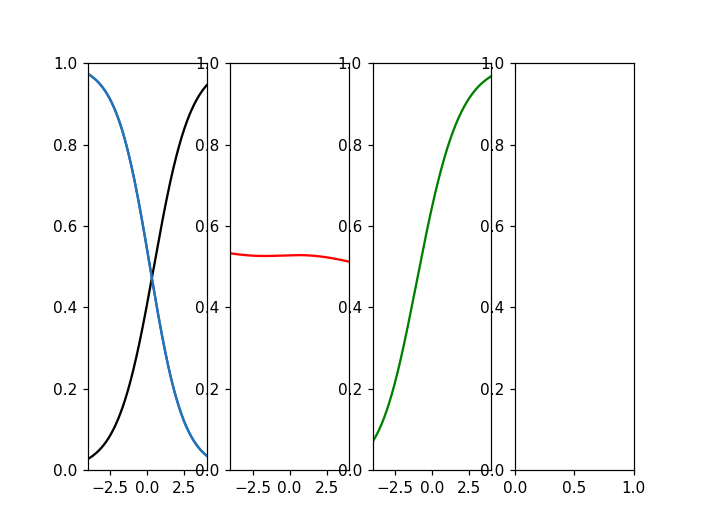

In [229]:

N , I = 10000 , 100 ; i = randi(I,N) ; x = np.sort( 8.0 * rand( N ) - 4.0 )

fig, ax = plt.subplots( 1,4 )

dgp = LogitDGP()
P = dgp.prob( x )
ax[0].plot( x , P , '-k' )
ax[0].set_xlim( [np.min(x),np.max(x)] ) ; ax[0].set_ylim( [0,1] )
dgp.draw( N , I , i , x )

dgp = LCLogitDGP( 3 )
P = dgp.prob( x )
ax[1].plot( x , P , '-r' )
ax[1].set_xlim( [np.min(x),np.max(x)] ) ; ax[1].set_ylim( [0,1] )
dgp.draw( N , I , i , x )

dgp = GRCLogitDGP( )
P = dgp.prob( x )
ax[2].plot( x , P , '-g' )
ax[2].set_xlim( [np.min(x),np.max(x)] ) ; ax[2].set_ylim( [0,1] )
dgp.draw( N , I , i , x )

s="""
P = MXGLogitDGP( 2 ).prob( x )
ax[3].plot( x , P , '-b' )
ax[3].set_xlim( [np.min(x),np.max(x)] ) ; ax[3].set_ylim( [0,1] )
"""

# Simulation Experiments

- - -

To draw a simulation experiment, we need to choose or draw $(N,I)$, then $i_n \in \{1,\dotsc,I\}$ for all $n$, and then choice dummies $y_n$ following some data generating process. Below we wrap the second two parts in a single function, `draw_experiment`. Then we create model object instances from the resultant data for each of our model types. 

Just to make sure everything works, we run a test that just (a) checks the gradient for each model and (b) fits the model on the data. 

<IPython.core.display.Javascript object>


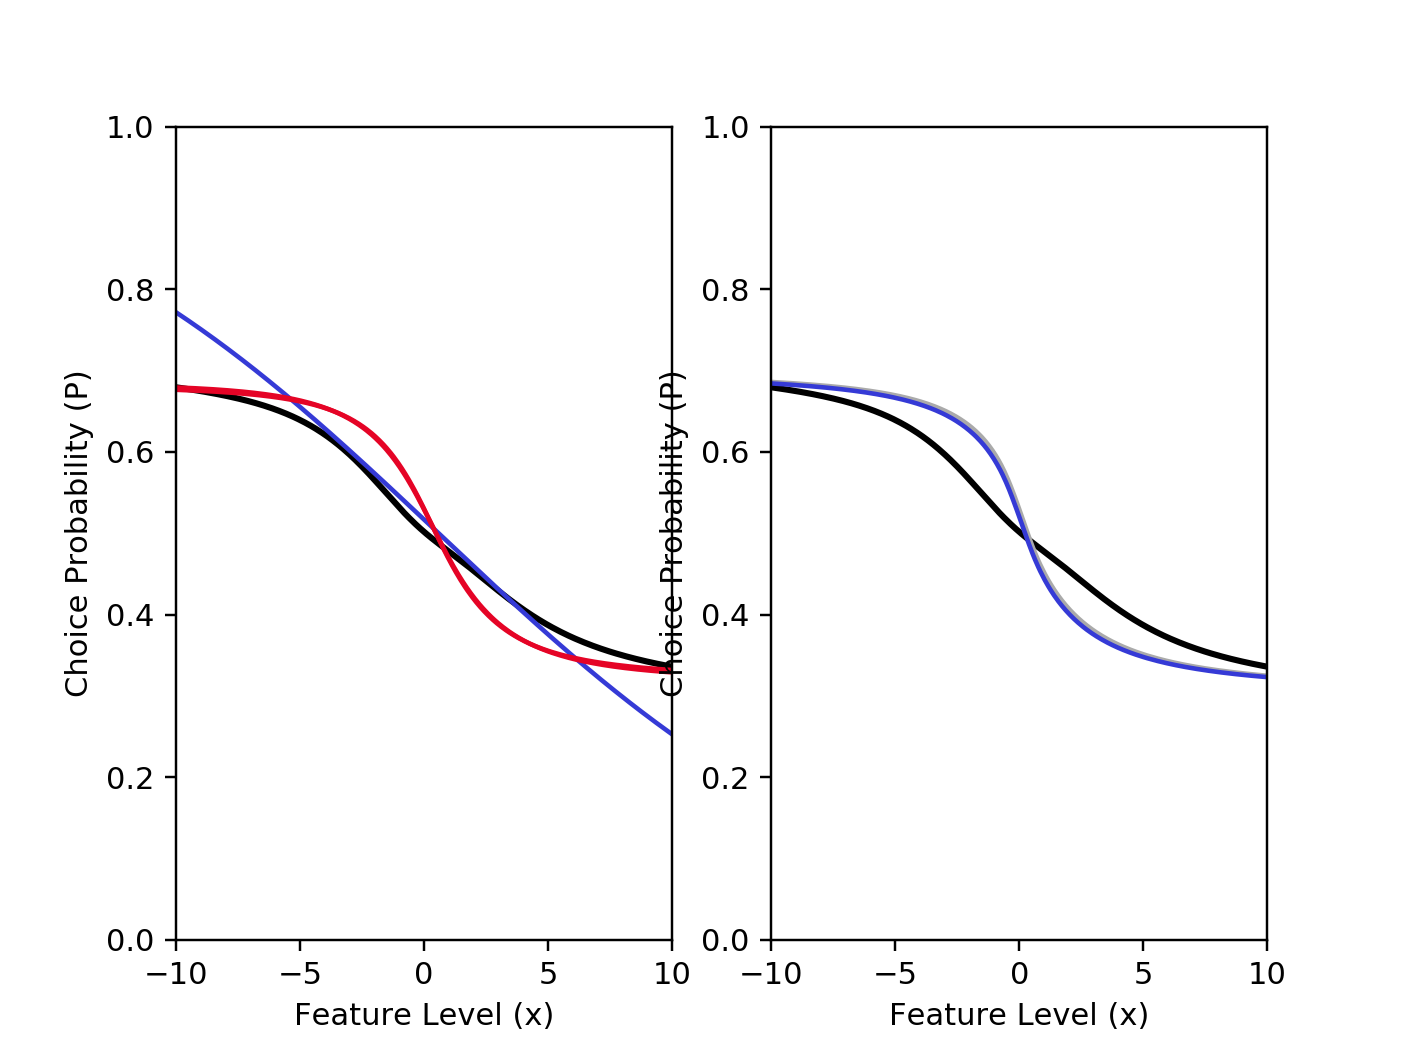

Logit :: Checking gradient...
0.1000000000000000 , 0.0304698724658623
0.0100000000000000 , 0.0034465818875615
0.0010000000000000 , 0.0003492033497752
0.0001000000000000 , 0.0000349663990926
0.0000100000000000 , 0.0000034970297595
0.0000010000000000 , 0.0000003495474852
0.0000001000000000 , 0.0000000360205030
0.0000000100000000 , 0.0000000537840714
0.0000000010000000 , 0.0000004090554393
0.0000000001000000 , 0.0000022554798198
Logit :: Fitting model...
Logit :: Solver ran in 0.069214 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: -0.12 , 0.07
 
idLogit :: Checking gradient...
idLogit :: Fitting model...
idLogit :: Solver ran in 0.348639 seconds
idLogit :: Solver message: ECOS converged
idLogit :: Formatted solution: -0.31 , 0.11 ( 0.69 , 0.89 ) , ( 0.0000 , 0.0000 )
 
idLogit :: Checking gradient...
0.1000000000000000 , 0.0117153264394561
0.0100000000000000 , 0.0012912115008219
0.0010000000000000 , 0.0001304561657718
0.0001000000

In [328]:
N , I = 1000 , 200
i , x = randi( I , N ) , 20.0 * rand( N ) - 10.0

ind = np.argsort( x )

# dgp = LogitDGP()
dgp = LCLogitDGP( 5 )
# dgp = GRCLogitDGP( )

PT = dgp.prob( x )

f , ax = plt.subplots(1,2)
for p in range(2) : 
    ax[p].plot( x[ind] , PT[ind] , '-k' , linewidth=2 )
    ax[p].set_xlim( [-10,10] )
    ax[p].set_ylim( [0,1] )
    ax[p].set_xlabel( 'Feature Level (x)' )
    ax[p].set_ylabel( 'Choice Probability (P)' )

y = dgp( N , I , i , x )

def basic_test( prob , linetype='-' , color=None , axis=ax[0] ) : 
    try : 
        print( "%s :: Checking gradient..." % ( prob.type ) )
        prob.grad_check(  )
    except Exception as e : 
        pass
    print( "%s :: Fitting model..." % ( prob.type ) )
    prob.fit( maxtime=45.0 )
    try : 
        if prob.soln['error'] or prob.soln['timeout'] : 
            print( "%s :: Solve attempt failed: %s" % ( prob.type , prob.soln['message'] ) )
        else : 
            print( "%s :: Solver ran in %0.6f seconds" % ( prob.type , prob.soln['solvertime'] ) )
            print( "%s :: Solver message: %s" % ( prob.type , prob.soln['message'] ) )
            print( "%s :: Formatted solution: %s" % ( prob.type , prob.printx() ) )
            P = prob.probs( x )
            if color is None : 
                axis.plot( x[ind] , P[ind] , linetype )
            else :
                axis.plot( x[ind] , P[ind] , linetype , color=color )
    except KeyError as ke : 
        print( prob.soln )
    
# define simple Logit
mnl = Logit( N , I , i , x , y )
basic_test( mnl , color="#353ad6" ) ; print(" ")

cvx = CVXidLogit( N , I , i , x , y , Lambda1=N/1e4 , Lambda2=0.0 )
basic_test( cvx , color="#aaaaaa" , axis=ax[1] ) ; print(" ")

idl = idLogit( N , I , i , x , y , Lambda1=N/1e4 , Lambda2=0.0 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")


saa = GRCLogitSAA( N , I , i , x , y )
basic_test( saa , color="#e50426" ) ; print(" ")

glq = GRCLogitGLQ( N , I , i , x , y )
basic_test( glq , color="#e50426" ) ; print(" ")

# cvx.fit() ; print( cvx.soln )

s="""
# define latent class Logit instances, for a specific number of modeled classes
M = 2

lcl = LatentClassLogit( N , I , i , x , y , M )
basic_test( lcl , color="#42f474" ) ; print(" ")

ccl = ClassClassLogit( N , I , i , x , y , M )
basic_test( ccl , linetype="--" , color="#207738" ) ; print(" ")

# define sample average and gauss-legendre random coefficient Logit instances

saa = GRCLogitSAA( N , I , i , x , y )
basic_test( saa , color="#e50426" ) ; print(" ")

#glq = GRCLogitGLQ( N , I , i , x , y )
# basic_test( glq ) ; print(" ")

# finally, define an idLogit instance
idl = idLogit( N , I , i , x , y )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.1*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.05*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.01*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.0005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.0001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.00005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")
"""

Ok, now that we have some confidence that everything actually works, we can run some _real_ tests. 



In [322]:
N , I = int(5e6) , 100
i , x = randi( I , N ) , 20.0 * rand( N ) - 10.0

# dgp = LogitDGP()
dgp = LCLogitDGP( 5 )
# dgp = GRCLogitDGP( )

y = dgp( N , I , i , x )

def idl_time_test( prob ) : 
    print( "%s :: Fitting model..." % ( prob.type ) )
    prob.fit( maxtime=(5.0*60.0) )
    try : 
        if prob.soln['error'] or prob.soln['timeout'] : 
            print( "%s :: Solve attempt failed: %s" % ( prob.type , prob.soln['message'] ) )
        else : 
            print( "%s :: Solver ran in %0.6f seconds" % ( prob.type , prob.soln['solvertime'] ) )
            print( "%s :: Solver message: %s" % ( prob.type , prob.soln['message'] ) )
            print( "%s :: Formatted solution: %s" % ( prob.type , prob.printx() ) )
            return prob.soln['solvertime'] , prob.soln['status']
    except KeyError as ke : 
        print( prob.soln )
    return None , None
    
log10Nmax = np.log10(N)
log10Ndel = ( log10Nmax - 3 ) / 25
Ns = [ int(N) for N in 10.0 ** np.arange( 3 , log10Nmax + 0.1 * log10Ndel , log10Ndel ) ]

times , stats = {} , {}
for k in ['mnl','cvx','nlp'] : 
    times[k] = [ None for n in range( len(Ns) ) ]
    stats[k] = [ None for n in range( len(Ns) ) ]
    
for n in range( len(Ns) ) : 
    
    N = Ns[n]
    
    mnl = Logit( N , I , i[:N] , x[:N] , y[:N] )
    times['mnl'][n] , stats['mnl'][n] = idl_time_test( mnl )

    cvx = CVXidLogit( N , I , i[:N] , x[:N] , y[:N] )
    times['cvx'][n] , stats['cvx'][n] = idl_time_test( cvx )

    nlp = idLogit( N , I , i[:N] , x[:N] , y[:N] )
    times['nlp'][n] , stats['nlp'][n] = idl_time_test( nlp )


Logit :: Fitting model...
Logit :: Solver ran in 0.062921 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: 0.16 , -0.00
idLogit :: Fitting model...
idLogit :: Solver ran in 0.181828 seconds
idLogit :: Solver message: ECOS converged
idLogit :: Formatted solution: 0.16 , -0.00 ( 0.00 , 0.00 ) , ( 0.0000 , 0.0000 )
idLogit :: Fitting model...
idLogit :: Solver ran in 0.712030 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.16 , -0.00 ( 0.00 , 0.00 ) , ( 0.0000 , 0.0000 )
Logit :: Fitting model...
Logit :: Solver ran in 0.051500 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: 0.17 , -0.05
idLogit :: Fitting model...
idLogit :: Solver ran in 0.206867 seconds
idLogit :: Solver message: ECOS converged
idLogit :: Formatted solution: 0.17 , -0.05 ( 0.00 , 0.00 ) , ( 0.0000 , 0.0000 )
idLogit :: Fitting model...
idLogit ::

<IPython.core.display.Javascript object>


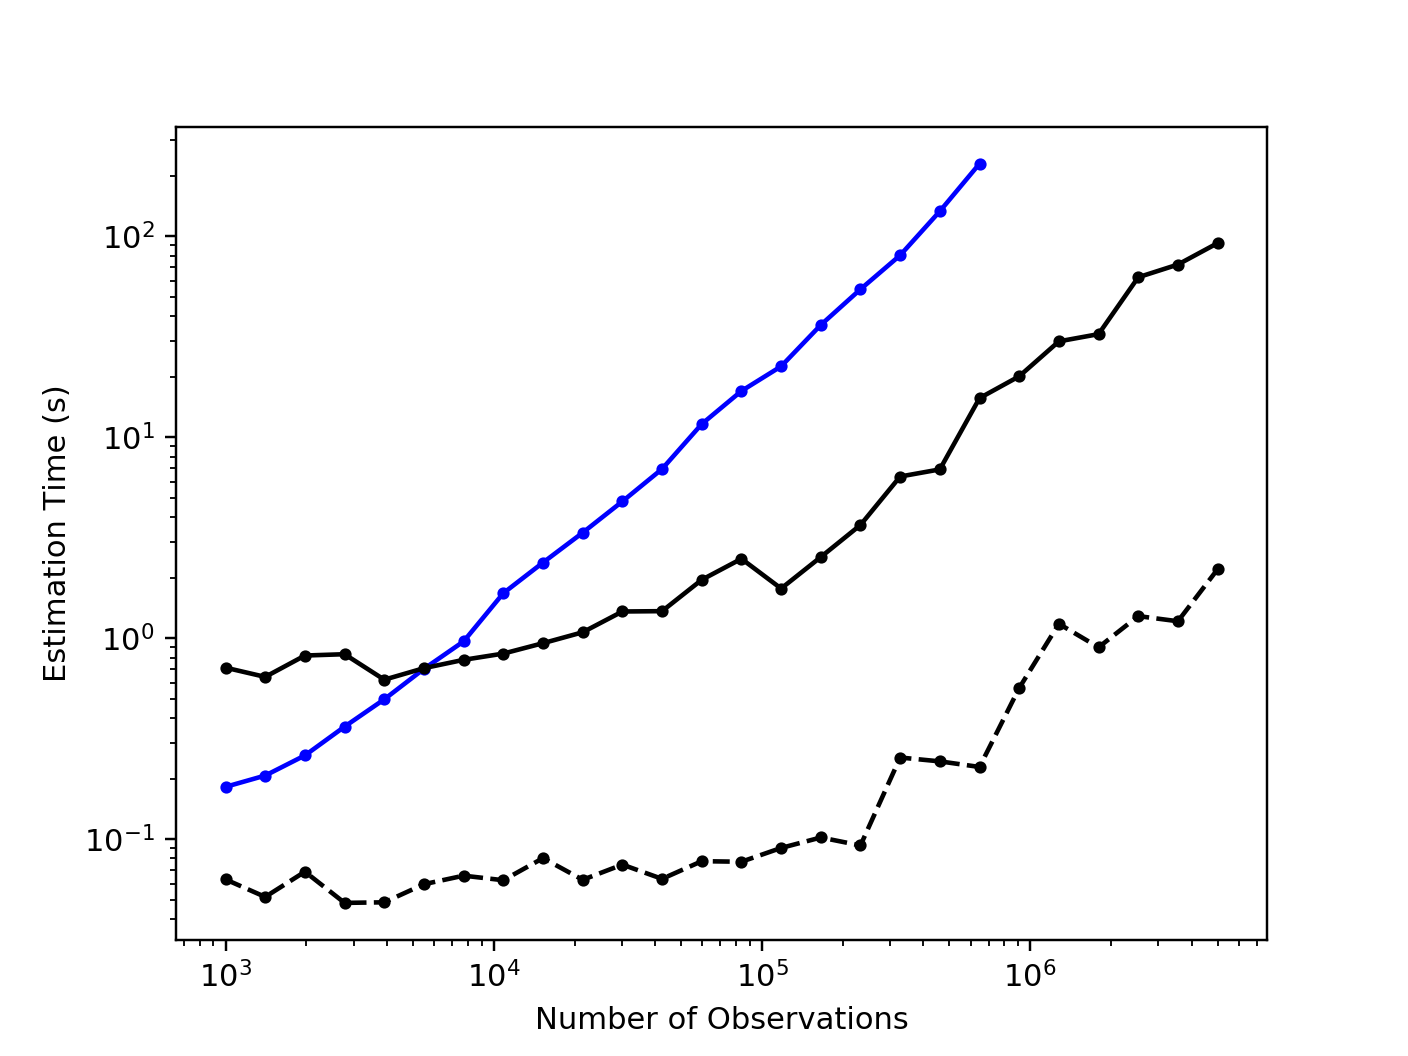

[   1000    1405    1976    2778    3906    5492    7722   10857   15264
   21459   30170   42417   59635   83842  117875  165722  232991  327566
  460530  647466  910282 1279778 1799258 2529603 3556404 5000000]
[  1000   1405   1976   2778   3906   5492   7722  10857  15264  21459
  30170  42417  59635  83842 117875 165722 232991 327566 460530 647466]
[   1000    1405    1976    2778    3906    5492    7722   10857   15264
   21459   30170   42417   59635   83842  117875  165722  232991  327566
  460530  647466  910282 1279778 1799258 2529603 3556404 5000000]


Text(0, 0.5, 'Estimation Time (s)')

In [323]:

lines = { 'mnl' : '--' , 'cvx' : '-' , 'nlp' : '-' }
color = { 'mnl' : 'black' , 'cvx' : 'blue' , 'nlp' : 'black' }
plt.figure()

Ns = np.array( Ns )

for k in ['mnl','cvx','nlp'] : 
    plt.loglog( Ns , times[k] , lines[k] , color=color[k] )
    stats[k] = np.array( stats[k] )
    times[k] = np.array( times[k] )
    ind = np.where( stats[k] == 1 )[0]
    if ind is not None : 
        print( Ns[ind] )
        plt.loglog( Ns[ind] , times[k][ind] , '.' , color=color[k] )
    ind = np.where( stats[k] == 2 )[0]
    if ind is not None : 
        plt.loglog( Ns[ind] , times[k][ind] , '+' , color=color[k] )
        
plt.xlabel( 'Number of Observations' )
plt.ylabel( 'Estimation Time (s)' )


<IPython.core.display.Javascript object>


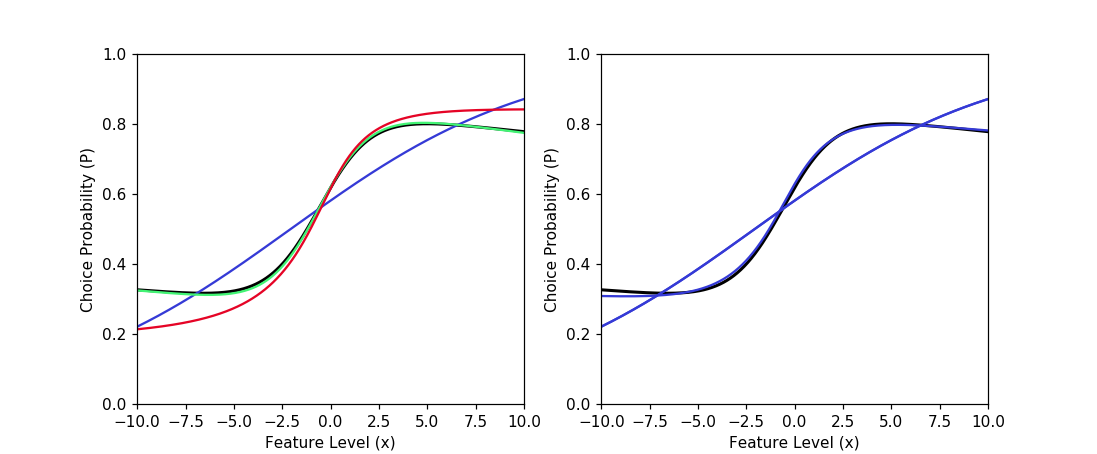

Logit :: Fitting model...
Logit :: Solver ran in 0.065154 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: 0.16 , 0.33
 
Latent Class Logit :: Fitting model...
Latent Class Logit :: Solver ran in 0.111358 seconds
Latent Class Logit :: Solver message: `gtol` termination condition is satisfied.
Latent Class Logit :: Formatted solution: ( -0.07 , 0.55 , 0.42 ) , ( 0.75 , 0.44 , 0.58 )
 
Class Class Logit :: Fitting model...


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in log


Class Class Logit :: Solve attempt failed: Solver timeout
 
Gaussian RC Logit (SAA) :: Fitting model...
Gaussian RC Logit (SAA) :: Solver ran in 13.194716 seconds
Gaussian RC Logit (SAA) :: Solver message: `gtol` termination condition is satisfied.
Gaussian RC Logit (SAA) :: Formatted solution: 0.44 ( 0.48 )
 
idLogit :: Fitting model...
idLogit :: Solver ran in 1.213980 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.16 , 0.33 ( 0.00 , 0.00 ) , ( 0.0000 , 0.0000 )
 
idLogit :: Fitting model...
idLogit :: Solver ran in 0.747366 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.16 , 0.33 ( 0.00 , 0.00 ) , ( 0.0000 , 0.0013 )
 
idLogit :: Fitting model...
idLogit :: Solver ran in 8.592612 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.40 , 0.53 ( 0.29 , 0.34 ) , ( 0.2132 , 0.0002 )
 


In [244]:
N , I = 5000 , 200
i , x = randi( I , N ) , 20.0 * rand( N ) - 10.0

ind = np.argsort( x )

# dgp = LogitDGP()
dgp = LCLogitDGP( 5 )
# dgp = GRCLogitDGP( )

PT = dgp.prob( x )

f , ax = plt.subplots(1,2)
for p in range(2) : 
    ax[p].plot( x[ind] , PT[ind] , '-k' , linewidth=2 )
    ax[p].set_xlim( [-10,10] )
    ax[p].set_ylim( [0,1] )
    ax[p].set_xlabel( 'Feature Level (x)' )
    ax[p].set_ylabel( 'Choice Probability (P)' )

y = dgp( N , I , i , x )

def basic_test( prob , linetype='-' , color=None , axis=ax[0] ) : 
    print( "%s :: Fitting model..." % ( prob.type ) )
    prob.fit( maxtime=45.0 )
    try : 
        if prob.soln['error'] or prob.soln['timeout'] : 
            print( "%s :: Solve attempt failed: %s" % ( prob.type , prob.soln['message'] ) )
        else : 
            print( "%s :: Solver ran in %0.6f seconds" % ( prob.type , prob.soln['solvertime'] ) )
            print( "%s :: Solver message: %s" % ( prob.type , prob.soln['message'] ) )
            print( "%s :: Formatted solution: %s" % ( prob.type , prob.printx() ) )
            P = prob.probs( x )
            if color is None : 
                axis.plot( x[ind] , P[ind] , linetype )
            else :
                axis.plot( x[ind] , P[ind] , linetype , color=color )
    except KeyError as ke : 
        print( prob.soln )
    
# define simple Logit
mnl = Logit( N , I , i , x , y )
basic_test( mnl , color="#353ad6" ) ; print(" ")

# define latent class Logit instances, for a specific number of modeled classes
M = 2

lcl = LatentClassLogit( N , I , i , x , y , M )
basic_test( lcl , color="#42f474" ) ; print(" ")

ccl = ClassClassLogit( N , I , i , x , y , M )
basic_test( ccl , linetype="--" , color="#207738" ) ; print(" ")

# define sample average and gauss-legendre random coefficient Logit instances

saa = GRCLogitSAA( N , I , i , x , y )
basic_test( saa , color="#e50426" ) ; print(" ")

#glq = GRCLogitGLQ( N , I , i , x , y )
# basic_test( glq ) ; print(" ")

# finally, define an idLogit instance
idl = idLogit( N , I , i , x , y )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.1*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s="""

L1 = 0.05*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.01*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.0005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

"""

L1 = 0.0001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s= """
L1 = 0.00005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")
"""

<IPython.core.display.Javascript object>


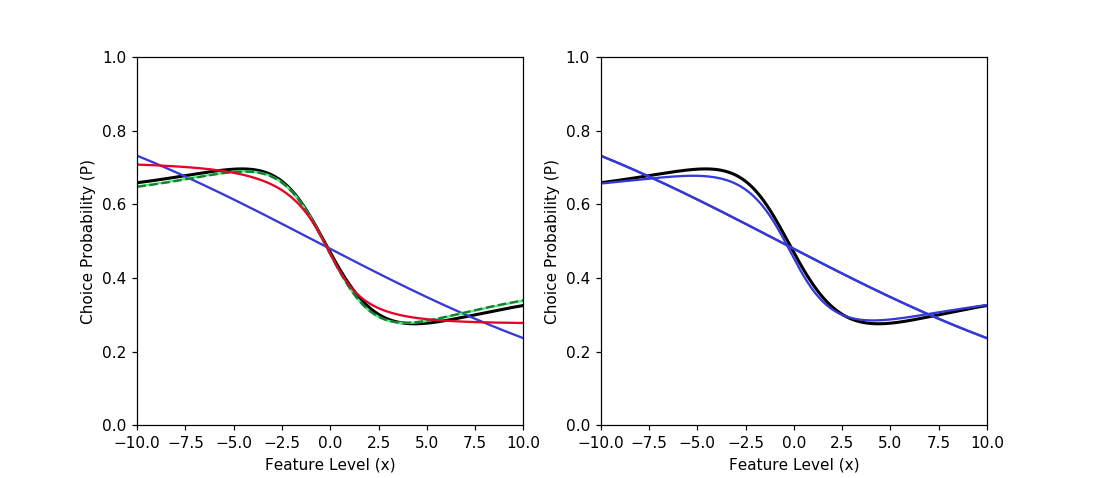

Logit :: Fitting model...
Logit :: Solver ran in 0.069467 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: -0.11 , -0.08
 
Latent Class Logit :: Fitting model...
Latent Class Logit :: Solver ran in 0.117975 seconds
Latent Class Logit :: Solver message: `gtol` termination condition is satisfied.
Latent Class Logit :: Formatted solution: ( -0.79 , -0.12 , 0.61 ) , ( 0.20 , -0.17 , 0.39 )
 
Class Class Logit :: Fitting model...
Class Class Logit :: Solver ran in 0.683665 seconds
Class Class Logit :: Solver message: `gtol` termination condition is satisfied.
Class Class Logit :: Formatted solution: ( -0.79 , 0.61 ) , ( 0.20 , 0.39 )
 
Gaussian RC Logit (SAA) :: Fitting model...
Gaussian RC Logit (SAA) :: Solver ran in 11.185297 seconds
Gaussian RC Logit (SAA) :: Solver message: `gtol` termination condition is satisfied.
Gaussian RC Logit (SAA) :: Formatted solution: -0.44 ( -0.14 )
 
idLogit :: Fitting model...
idLogit :: Solver ran i

In [246]:
N , I = 5000 , 200
i , x = randi( I , N ) , 20.0 * rand( N ) - 10.0

ind = np.argsort( x )

# dgp = LogitDGP()
dgp = LCLogitDGP( 5 )
# dgp = GRCLogitDGP( )

PT = dgp.prob( x )

f , ax = plt.subplots(1,2)
for p in range(2) : 
    ax[p].plot( x[ind] , PT[ind] , '-k' , linewidth=2 )
    ax[p].set_xlim( [-10,10] )
    ax[p].set_ylim( [0,1] )
    ax[p].set_xlabel( 'Feature Level (x)' )
    ax[p].set_ylabel( 'Choice Probability (P)' )

y = dgp( N , I , i , x )

def basic_test( prob , linetype='-' , color=None , axis=ax[0] ) : 
    print( "%s :: Fitting model..." % ( prob.type ) )
    prob.fit( maxtime=45.0 )
    try : 
        if prob.soln['error'] or prob.soln['timeout'] : 
            print( "%s :: Solve attempt failed: %s" % ( prob.type , prob.soln['message'] ) )
        else : 
            print( "%s :: Solver ran in %0.6f seconds" % ( prob.type , prob.soln['solvertime'] ) )
            print( "%s :: Solver message: %s" % ( prob.type , prob.soln['message'] ) )
            print( "%s :: Formatted solution: %s" % ( prob.type , prob.printx() ) )
            P = prob.probs( x )
            if color is None : 
                axis.plot( x[ind] , P[ind] , linetype )
            else :
                axis.plot( x[ind] , P[ind] , linetype , color=color )
    except KeyError as ke : 
        print( prob.soln )
    
# define simple Logit
mnl = Logit( N , I , i , x , y )
basic_test( mnl , color="#353ad6" ) ; print(" ")

# define latent class Logit instances, for a specific number of modeled classes
M = 2

lcl = LatentClassLogit( N , I , i , x , y , M )
basic_test( lcl , color="#42f474" ) ; print(" ")

ccl = ClassClassLogit( N , I , i , x , y , M )
basic_test( ccl , linetype="--" , color="#207738" ) ; print(" ")

# define sample average and gauss-legendre random coefficient Logit instances

saa = GRCLogitSAA( N , I , i , x , y )
basic_test( saa , color="#e50426" ) ; print(" ")

#glq = GRCLogitGLQ( N , I , i , x , y )
# basic_test( glq ) ; print(" ")

# finally, define an idLogit instance
idl = idLogit( N , I , i , x , y )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.1*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s="""

L1 = 0.05*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.01*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.0005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

"""

L1 = 0.0001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s= """
L1 = 0.00005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")
"""

<IPython.core.display.Javascript object>


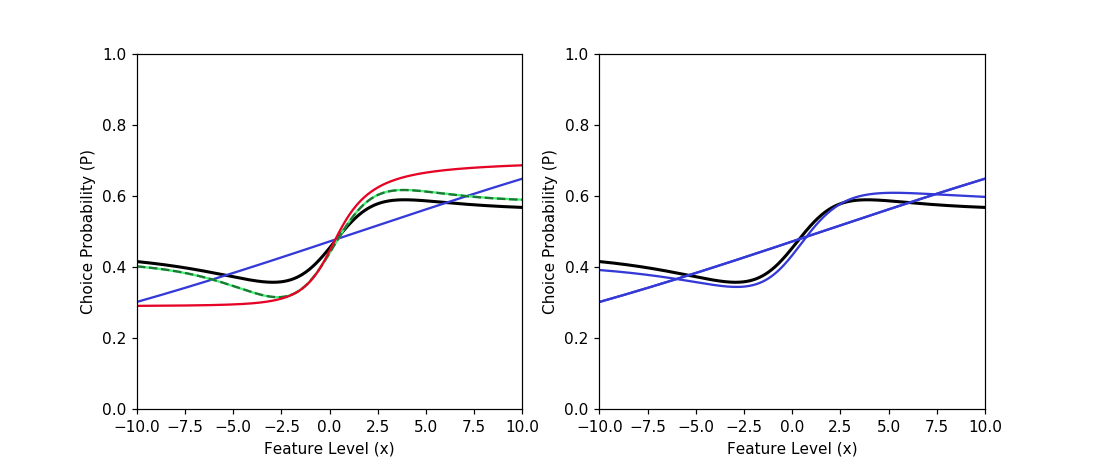

Logit :: Fitting model...
Logit :: Solver ran in 0.054180 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: 0.07 , -0.11
 
Latent Class Logit :: Fitting model...
Latent Class Logit :: Solver ran in 0.117428 seconds
Latent Class Logit :: Solver message: `gtol` termination condition is satisfied.
Latent Class Logit :: Formatted solution: ( -0.39 , -0.40 , 0.42 ) , ( 0.88 , -0.13 , 0.58 )
 
Class Class Logit :: Fitting model...


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in log


Class Class Logit :: Solver ran in 1.657217 seconds
Class Class Logit :: Solver message: `gtol` termination condition is satisfied.
Class Class Logit :: Formatted solution: ( -0.39 , 0.42 ) , ( 0.88 , 0.58 )
 
Gaussian RC Logit (SAA) :: Fitting model...
Gaussian RC Logit (SAA) :: Solver ran in 18.997083 seconds
Gaussian RC Logit (SAA) :: Solver message: `gtol` termination condition is satisfied.
Gaussian RC Logit (SAA) :: Formatted solution: 0.43 ( -0.25 )
 
idLogit :: Fitting model...


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: overflow encountered in log1p
/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: invalid value encountered in log1p


idLogit :: Solver ran in 1.255249 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.07 , -0.11 ( 0.00 , 0.00 ) , ( 0.0196 , 0.0000 )
 
idLogit :: Fitting model...


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: overflow encountered in log1p
/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: invalid value encountered in log1p


idLogit :: Solver ran in 0.782249 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.07 , -0.11 ( 0.00 , 0.00 ) , ( 0.0126 , 0.0001 )
 
idLogit :: Fitting model...


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: overflow encountered in log1p
/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: invalid value encountered in log1p


idLogit :: Solver ran in 7.538958 seconds
idLogit :: Solver message: `gtol` termination condition is satisfied.
idLogit :: Formatted solution: 0.28 , -0.26 ( 0.43 , 0.46 ) , ( 0.0507 , 0.0119 )
 


In [249]:
N , I = 10000 , 200
i , x = randi( I , N ) , 20.0 * rand( N ) - 10.0

ind = np.argsort( x )

# dgp = LogitDGP()
dgp = LCLogitDGP( 5 )
# dgp = GRCLogitDGP( )

PT = dgp.prob( x )

f , ax = plt.subplots(1,2)
for p in range(2) : 
    ax[p].plot( x[ind] , PT[ind] , '-k' , linewidth=2 )
    ax[p].set_xlim( [-10,10] )
    ax[p].set_ylim( [0,1] )
    ax[p].set_xlabel( 'Feature Level (x)' )
    ax[p].set_ylabel( 'Choice Probability (P)' )

y = dgp( N , I , i , x )

def basic_test( prob , linetype='-' , color=None , axis=ax[0] ) : 
    print( "%s :: Fitting model..." % ( prob.type ) )
    prob.fit( maxtime=45.0 )
    try : 
        if prob.soln['error'] or prob.soln['timeout'] : 
            print( "%s :: Solve attempt failed: %s" % ( prob.type , prob.soln['message'] ) )
        else : 
            print( "%s :: Solver ran in %0.6f seconds" % ( prob.type , prob.soln['solvertime'] ) )
            print( "%s :: Solver message: %s" % ( prob.type , prob.soln['message'] ) )
            print( "%s :: Formatted solution: %s" % ( prob.type , prob.printx() ) )
            P = prob.probs( x )
            if color is None : 
                axis.plot( x[ind] , P[ind] , linetype )
            else :
                axis.plot( x[ind] , P[ind] , linetype , color=color )
    except KeyError as ke : 
        print( prob.soln )
    
# define simple Logit
mnl = Logit( N , I , i , x , y )
basic_test( mnl , color="#353ad6" ) ; print(" ")

# define latent class Logit instances, for a specific number of modeled classes
M = 2

lcl = LatentClassLogit( N , I , i , x , y , M )
basic_test( lcl , color="#42f474" ) ; print(" ")

ccl = ClassClassLogit( N , I , i , x , y , M )
basic_test( ccl , linetype="--" , color="#207738" ) ; print(" ")

# define sample average and gauss-legendre random coefficient Logit instances

saa = GRCLogitSAA( N , I , i , x , y )
basic_test( saa , color="#e50426" ) ; print(" ")

#glq = GRCLogitGLQ( N , I , i , x , y )
# basic_test( glq ) ; print(" ")

# finally, define an idLogit instance
idl = idLogit( N , I , i , x , y )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.1*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s="""

L1 = 0.05*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.01*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.0005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

"""

L1 = 0.0001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s= """
L1 = 0.00005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")
"""

In [257]:
N , I = 25000 , 500
i , x = randi( I , N ) , 20.0 * rand( N ) - 10.0

ind = np.argsort( x )

# dgp = LogitDGP()
dgp = LCLogitDGP( 5 )
# dgp = GRCLogitDGP( )

PT = dgp.prob( x )

f , ax = plt.subplots(1,2)
for p in range(2) : 
    ax[p].plot( x[ind] , PT[ind] , '-k' , linewidth=2 )
    ax[p].set_xlim( [-10,10] )
    ax[p].set_ylim( [0,1] )
    ax[p].set_xlabel( 'Feature Level (x)' )
    ax[p].set_ylabel( 'Choice Probability (P)' )

y = dgp( N , I , i , x )

def basic_test( prob , linetype='-' , color=None , axis=ax[0] ) : 
    print( "%s :: Checking gradient..." % ( prob.type ) )
    prob.grad_check(  )
    print( "%s :: Fitting model..." % ( prob.type ) )
    prob.fit( maxtime=( 10 * 60 ) )
    try : 
        if prob.soln['error'] or prob.soln['timeout'] : 
            print( "%s :: Solve attempt failed: %s" % ( prob.type , prob.soln['message'] ) )
        else : 
            print( "%s :: Solver ran in %0.6f seconds" % ( prob.type , prob.soln['solvertime'] ) )
            print( "%s :: Solver message: %s" % ( prob.type , prob.soln['message'] ) )
            print( "%s :: Formatted solution: %s" % ( prob.type , prob.printx() ) )
            P = prob.probs( x )
            if color is None : 
                axis.plot( x[ind] , P[ind] , linetype )
            else :
                axis.plot( x[ind] , P[ind] , linetype , color=color )
    except KeyError as ke : 
        print( prob.soln )
    
# define simple Logit
mnl = Logit( N , I , i , x , y )
basic_test( mnl , color="#353ad6" ) ; print(" ")

# finally, define an idLogit instance
idl = idLogit( N , I , i , x , y )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.1*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s="""

L1 = 0.05*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.01*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

L1 = 0.0005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

"""

L1 = 0.0001*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")

s= """
L1 = 0.00005*N ; idl.regularize( Lambda1=L1 , Lambda2=L1 )
basic_test( idl , linetype="-" , color="#353ad6" , axis=ax[1] ) ; print(" ")
"""

# define latent class Logit instances, for a specific number of modeled classes
M = 2

lcl = LatentClassLogit( N , I , i , x , y , M )
basic_test( lcl , color="#42f474" ) ; print(" ")

ccl = ClassClassLogit( N , I , i , x , y , M )
basic_test( ccl , linetype="--" , color="#207738" ) ; print(" ")

# define sample average and gauss-legendre random coefficient Logit instances

saa = GRCLogitSAA( N , I , i , x , y )
basic_test( saa , color="#e50426" ) ; print(" ")

#glq = GRCLogitGLQ( N , I , i , x , y )
# basic_test( glq ) ; print(" ")

<IPython.core.display.Javascript object>

Logit :: Checking gradient...
0.1000000000000000 , 0.1147751112527491
0.0100000000000000 , 0.0131414874827525
0.0010000000000000 , 0.0013325926506532
0.0001000000000000 , 0.0001334455458176
0.0000100000000000 , 0.0000133464185077
0.0000010000000000 , 0.0000013347046620
0.0000001000000000 , 0.0000001339984608
0.0000000100000000 , 0.0000000218659353
0.0000000010000000 , 0.0000000329681656
0.0000000001000000 , 0.0000005231115877
Logit :: Fitting model...
Logit :: Solver ran in 0.063299 seconds
Logit :: Solver message: `gtol` termination condition is satisfied.
Logit :: Formatted solution: 0.22 , 0.40
 
idLogit :: Checking gradient...
0.1000000000000000 , 0.0889767280300134
0.0100000000000000 , 0.0098100659310716
0.0010000000000000 , 0.0009903965842227
0.0001000000000000 , 0.0000991334995546
0.0000100000000000 , 0.0000099234379944
0.0000010000000000 , 0.0000010331272847
0.0000001000000000 , 0.0000015266008967
0.0000000100000000 , 0.0000144062218283
0.0000000010000000 , 0.0001474583621344
0

Process Process-264:
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/queues.py", line 191, in _finalize_join
    thread.join()


KeyboardInterrupt: 

  File "/Users/morrowwr/anaconda/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/Users/morrowwr/anaconda/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


The following code helps us abstract away from the mechanics of doing the tests themselves. 

In [155]:

def create_model_object( code , N , I , i , x , y , data={} ) : 
    """
    This is a convenience function for instantiating model objects from a 
    code, basic data shared by all models, and optional additional data that
    a class might require or use. 
    """
    if data is None : data = {} # generic empty object for use 
    if   code == "mnl" : return Logit( N , I , i[:N] , x[:N] , y[:N] )
    elif code == "lcl" : return LatentClassLogit( N , I , i[:N] , x[:N] , y[:N] , **data )
    elif code == "ccl" : return ClassClassLogit( N , I , i[:N] , x[:N] , y[:N] , **data )
    elif code == "saa" : return GRCLogitSAA( N , I , i[:N] , x[:N] , y[:N] )
    elif code == "glq" : return GRCLogitGLQ( N , I , i[:N] , x[:N] , y[:N] )
    elif code == "idl" : return idLogit( N , I , i[:N] , x[:N] , y[:N] , **data )
    else : return None
    
def fit_model( prob , p0=None , PT=None , timeout=None , verbose=True ) : 
    
    res = { 'N' : prob.N , 'p' : None , 'x' : None , 'k' : None , \
               't' : None , 'e' : True , 'm' : None , 's' : None }
    
    try : 
        prob.fit( maxtime=timeout , p0=p0 )
        if prob.soln is None    : raise Exception( "indeterminate solver error" )
        if prob.soln['timeout'] : raise Exception( "solver timeout" )
        if prob.soln['error']   : raise prob.soln['message']
        res['s'] = prob.soln['status']
        res['p'] = prob.printx()
        res['x'] = prob.getx()
        res['t'] = prob.soln['solvertime']
        res['e'] = prob.soln['error']
        res['m'] = prob.soln['message']
        if ( PT is not None ) and ( not prob.soln['error'] ) : res['k'] = prob.kld( PT )
        if verbose : 
            print( "%s :: Solve attempt finished (%i) for N = %i" \
                      % ( prob.type , prob.soln['status'] , prob.N ) )
            
    except Exception as e : 
        if verbose : print( "%s :: solve exception occurred: %s" % ( prob.type , e ) )
        try : solvertime = prob.soln['solvertime']
        except AttributeError as ae : solvertime = None
        res['t'] , res['e'] , res['m'] = solvertime , True , e
        
    return res
    
def fit_sequence( Ns , I , i , x , y , code , data , PT=None , timeout=None , chain=True , verbose=True ) :
    """
    This is a convenience function for running a sequence of fits over 
    increasing numbers of observations with structured initial conditions. 
    We can either "chain" the solves by passing the solution for one problem
    to the next, or not and keep the same inital condition
    """
    results , prob_type , p0 = [] , None , None
    for N in Ns : 
        prob , res = None , None
        try :
            prob = create_model_object( code , N , I , i , x , y , data )
            if prob_type is None : prob_type = prob.type
        except Exception as e : 
            print( "Error creating model object: " , e )
        if prob is not None : 
            res = fit_model( prob , p0=p0 , PT=PT , timeout=timeout , verbose=verbose )
            if not res['e'] : 
                p0 = prob.soln['x'] if chain else prob.soln['x0']
        results.append( res )
    return results, prob_type

class FitSequenceTrial( object ) :
    """
    This is a wrapper class to enable parallelization with pool.map by 
    making a callable object instance storing the desired model data. 
    """
    def __init__( self , Ns , I , i , x , y , PT=None , timeout=None , verbose=None ) : 
        self.Ns , self.I , self.i , self.x , self.y = Ns , I , i , x , y
        self.timeout , self.verbose = timeout , verbose
    def __call__( self , params ) : # expects params = { code , data , trial }  
        return fit_sequence( self.Ns , self.I , self.i , self.x , self.y , params['code'] , params['data'] , \
                                PT=PT , timeout=self.timeout , verbose=self.verbose )
    

Now we define a class `ModelFitExp` to facilitate running experiments over the sample size ($N$) -- with the same observsational data -- for a variety of models. 

In [158]:

class ModelFitExp( object ) : 
    
    def __init__( self , I=0 , dgp=None , obsvnums=None , timeout=None , \
                     models=None , trials=None , processes=None , verbose=True ) : 
        self.I = I 
        self.dgp = dgp
        self.timeout = timeout
        self.models = {}
        self.verbose = verbose
        self.T = trials if trials is not None else 1 # one trial by default
        if models is not None : 
            for m in models : 
                self.add_model( m['code'] , data=( m['data'] if 'data' in m else None ) )
        self.results = {}
        self.Ns = []
        if obsvnums is None : 
            self.Ns = [ int(N) for N in 10.0 ** np.arange( 3 , 6.1 , 0.1 ) ]
        else : 
            self.Ns = obsvnums
        self.P = 1
        self.parallelize( processes )
        self.ixy_saved = False
        
        self.PT = None
    
    def be_verbose( self ) : 
        self.verbose = True
        
    def be_quiet( self ) : 
        self.verbose = False
    
    def set_obsnums( self , Nmin , Nmax , Nnum ) : 
        try : 
            Ndel = ( Nmax - Nmin ) / Nnum
            self.Ns = [ int(N) for N in 10.0 ** np.arange( Nmin , Nmax + 0.5*Ndel , Ndel ) ]
        except Exception as e : 
            self.Ns = None
            raise e
            
    def set_dgp( self , dgp ) : 
        self.dgp = dgp
    
    def set_timeout( self , timeout ) : 
        self.timeout = timeout
        
    def add_model( self , code , data=None ) : 
        mid = random_string( 16 )
        self.models[mid] = { 'code' : code , 'data' : data }
        return mid
        
    def del_model( self , mid ) : 
        if mid in self.models : 
            del self.models[mid]
            
    def clear_models( self ) : 
        del self.models
        self.models = {}
        
    def reset_results( self ) : 
        del self.results
        self.results = {}
        
    def parallelize( self , procs ) : 
        try : self.P = int( procs )
        except Exception as e : pass
        if self.P < 1 : self.P = 1
        
    def print_models( self ) : 
        for k in self.models : 
            print( "(%s) %s %s" % ( k , self.models[k]['code'] , \
                                   str(self.models[k]['data']) if self.models[k]['data'] is not None else "" ) )
        
    def print_results( self ) : 
        for k in self.results : 
            print( "%s%s" % ( self.models[k]['type'] , "" if self.models[k]['data'] is None \
                                 else ", %s" % str(self.models[k]['data']) ) )
            t = 1
            for trial in self.results[k] : 
                for i in trial : 
                    if i['e'] : 
                        print( "%i , %i (%s) , %s" \
                                  % ( t , i['N'] , "-" if i['s'] is None else "%i" % i['s'] , i['m'] ) )
                    else :
                        print( "%i , %i (%s) , %0.2fs , %s " \
                                  % ( t , i['N'] , "-" if i['s'] is None else "%i" % i['s'] , i['t'] , i['p'] ) )
                        #print( "%i , %i (%s) , %0.2fs , %0.3f , %s " \
                        #          % ( t , i['N'] , "-" if i['s'] is None else "%i" % i['s'] , \
                        #               i['t'] , np.exp( - i['k'] ) , i['p'] ) )
                print( " " )
                t += 1
    
    def run( self , trials=None , save=False , resample=False ) : 
        
        if trials is not None : self.T = trials
        if self.ixy_saved and ( not resample ) : 
            i , x , y = self.i , self.x , self.y
        else : 
            i , x = randi( self.I , self.Ns[-1] ) , randn( self.Ns[-1] )
            y = self.dgp( self.Ns[-1] , self.I , i , x )
            if save : 
                self.i , self.x , self.y , self.ixy_saved = i , x , y , True
                
        # parallelize? May not be worthwhile. 
        if self.P > 1 : 
            map_params = []
            for k in self.models : 
                if k not in self.results : self.results[k] = [ [] for t in range(self.T) ]
                for t in range( self.T ) : 
                    map_params.append( { 
                        'code'  : self.models[k]['code'] ,
                        'data'  : self.models[k]['data'] ,
                        'trial' : t
                    } )
            with ThreadPool( processes=self.P ) as pool : 
                FST = FitSequenceTrial( self.Ns , self.I , i , x , y , \
                                           PT=self.PT , timeout=self.timeout , verbose=self.verbose )
                results = pool.map( FST , map_params )
            j = 0
            for k in self.models : 
                for t in range( self.T ) : 
                    self.results[k][t] , self.models[k]['type'] = results[j][0] , results[j][1]
                    j += 1
                    
        # serial trials; seems to be the best
        else : 
            for k in self.models : 
                if k not in self.results : self.results[k] = []
                for t in range( self.T ) : 
                    while t >= len( self.results[k] ) : self.results[k].append( [] )
                    self.results[k][t] , self.models[k]['type'] \
                        = fit_sequence( self.Ns , self.I , i , x , y , \
                                        self.models[k]['code'] , self.models[k]['data'] , \
                                        PT=self.PT , timeout=self.timeout , verbose=self.verbose )
            

### Logit data

Let's take the simplest case in the data, the Logit DGP, but try out each model with more and more data. This will help us _start_ to gauge comparative efficiency. To start, we will apply a one minute (60 second) timeout on the fit attempts. 

In [159]:

mdls = [
    { 'code' : 'mnl' } , 
    { 'code' : 'lcl' , 'data' : { 'C' : 3 } } , 
    { 'code' : 'ccl' , 'data' : { 'C' : 3 } } , 
    { 'code' : 'saa' } , 
    { 'code' : 'glq' } , 
    { 'code' : 'idl' } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' : 10.0 , 'Lambda2' : 1.0 } } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' :  1.0 , 'Lambda2' : 1.0 } } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' :  0.1 , 'Lambda2' : 1.0 } } , 
]
fitr = ModelFitExp( I=100 , dgp=LogitDGP() , timeout=60 , models=mdls , trials=2 , verbose=False )
# fitr.set_obsnums( 3 , 6 , 25 )
# fitr.set_obsnums( 3 , 5 , 20 )
fitr.set_obsnums( 3 , 4 , 10 )

fitr.run()

fitr.print_results()


/Users/morrowwr/anaconda/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Logit
1 , 1000 (1) , 0.03s , 0.14 
1 , 1258 (1) , 0.03s , 0.08 
1 , 1584 (1) , 0.03s , 0.10 
1 , 1995 (1) , 0.03s , 0.09 
1 , 2511 (1) , 0.03s , 0.11 
1 , 3162 (1) , 0.03s , 0.09 
1 , 3981 (1) , 0.02s , 0.09 
1 , 5011 (1) , 0.02s , 0.09 
1 , 6309 (1) , 0.02s , 0.08 
1 , 7943 (1) , 0.02s , 0.07 
1 , 10000 (1) , 0.03s , 0.07 
 
2 , 1000 (1) , 0.03s , 0.14 
2 , 1258 (1) , 0.02s , 0.08 
2 , 1584 (1) , 0.02s , 0.10 
2 , 1995 (1) , 0.02s , 0.09 
2 , 2511 (1) , 0.02s , 0.11 
2 , 3162 (1) , 0.02s , 0.09 
2 , 3981 (1) , 0.02s , 0.09 
2 , 5011 (1) , 0.02s , 0.09 
2 , 6309 (1) , 0.02s , 0.08 
2 , 7943 (1) , 0.02s , 0.07 
2 , 10000 (1) , 0.03s , 0.07 
 
Latent Class Logit, {'C': 3}
1 , 1000 (1) , 0.06s , ( 0.14 , 0.62 ) , ( 0.14 , 0.30 ) , ( 0.14 , 0.08 ) 
1 , 1258 (1) , 0.06s , ( 0.08 , 0.61 ) , ( 0.08 , 0.29 ) , ( 0.08 , 0.10 ) 
1 , 1584 (1) , 0.06s , ( 0.10 , 0.61 ) , ( 0.10 , 0.30 ) , ( 0.10 , 0.10 ) 
1 , 1995 (1) , 0.06s , ( 0.09 , 0.61 ) , ( 0.09 , 0.30 ) , ( 0.09 , 0.10 ) 
1 , 2511 (1) , 0.

### Latent Class Logit data

Let's try Latent Class Logit data.  

In [ ]:

mdls = [
    { 'code' : 'mnl' } , 
    { 'code' : 'lcl' , 'data' : { 'C' : 3 } } , 
    { 'code' : 'ccl' , 'data' : { 'C' : 3 } } , 
    { 'code' : 'saa' } , 
    { 'code' : 'glq' } , 
    { 'code' : 'idl' } ,  
    { 'code' : 'idl' , 'data' : { 'Lambda1' : 10.0 , 'Lambda2' : 0.0 } } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' :  1.0 , 'Lambda2' : 0.0 } } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' :  0.1 , 'Lambda2' : 0.0 } } , 
]

dgp = lambda N,I,i : lcl_dgp( N , I , i , 5 )

fitr = ModelFitExp( I=100 , dgp=dgp , timeout=60 , models=mdls , trials=1 , verbose=False )
# fitr.set_obsnums( 3 , 6 , 25 )
fitr.set_obsnums( 3 , 5 , 15 )

fitr.run()
fitr.print_results()


### Random (Gaussian) Coefficient Logit data

Let's look at the Gaussian coefficient case now. 

In [443]:

mdls = [
    { 'code' : 'mnl' } , 
    #{ 'code' : 'lcl' , 'data' : { 'C' : 3 } } , 
    #{ 'code' : 'ccl' , 'data' : { 'C' : 3 } } , 
    #{ 'code' : 'saa' } , 
    #{ 'code' : 'glq' } , 
    { 'code' : 'idl' } ,  
    { 'code' : 'idl' , 'data' : { 'Lambda1' : 10.0 , 'Lambda2' : 0.0 } } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' :  1.0 , 'Lambda2' : 0.0 } } , 
    { 'code' : 'idl' , 'data' : { 'Lambda1' :  0.1 , 'Lambda2' : 0.0 } } , 
]
dgp = lambda N,I,i : grc_dgp(N,I,i,sigma=0.5)
fitr = ModelFitExp( I=1000 , dgp=dgp , timeout=60 , models=mdls , trials=1 , verbose=True )
# fitr.set_obsnums( 3 , 6 , 25 )
fitr.set_obsnums( 3 , 5 , 15 )

fitr.run()
fitr.print_results()


[0.40146857 0.5       ]
Logit :: Solve attempt finished (1) for N = 1000
Logit :: Solve attempt finished (1) for N = 1359
Logit :: Solve attempt finished (1) for N = 1847
Logit :: Solve attempt finished (1) for N = 2511
Logit :: Solve attempt finished (1) for N = 3414
Logit :: Solve attempt finished (1) for N = 4641
Logit :: Solve attempt finished (1) for N = 6309
Logit :: Solve attempt finished (1) for N = 8576
Logit :: Solve attempt finished (1) for N = 11659
Logit :: Solve attempt finished (1) for N = 15848
Logit :: Solve attempt finished (1) for N = 21544
Logit :: Solve attempt finished (1) for N = 29286
Logit :: Solve attempt finished (1) for N = 39810
Logit :: Solve attempt finished (1) for N = 54116
Logit :: Solve attempt finished (1) for N = 73564
Logit :: Solve attempt finished (1) for N = 100000


Process Process-5888:
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/queues.py", line 191, in _finalize_join
    thread.join()
Traceback (most recent call last):
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/Users/morrowwr/anaconda/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/Users/morrowwr/anaconda/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/Users/morrowwr/anaconda/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


KeyboardInterrupt: 